# Machine Learning Approach to the Assessment and Prediction of Solid Particle Erosion of Metals 

This notebook reproduces the results published in the research paper "Machine Learning Approach to the Assessment and Prediction of Solid Particle Erosion of Metals" by authors S. Brown, F. Khomh, M. Cavarroc-Weimer, M. Mendez, L. Martinu and J.E. Klemberg-Sapieha




# Imports and setup

In [1]:
import os
import re
import numpy as np
import pandas as pd
import sklearn
import xgboost
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.style.use('seaborn-whitegrid')
np.set_printoptions(suppress=True) #Prevent some values from printing in scientific notation.


In [2]:
print(f"sklearn version: {sklearn.__version__}")
print(f"XGBoost version: {xgboost.__version__}")

sklearn version: 1.0.2
XGBoost version: 1.7.6


## Functions to run

In [3]:
def data_size_tester(X_train, y_train, X_test, y_test, model):
  """Fits a model to datasets representing 5-100% of the available training data. 
  Then assesses model performance on the full set of test data. Returns 
  the test score for each dataset size, in order to plot the effect of data 
  availability on model performance.
  """

  for i in range(5,101,5):
      
    # Create a sample of the data. Non-random since data is already shuffled
    growing_data_X = X_train[:int(X_train.shape[0]*i/100)]
    growing_data_y = y_train[:int(y_train.shape[0]*i/100)]

    # fit model using current sample, and record scores
    model_instance = model
    model_instance.fit(growing_data_X, growing_data_y)

    mae_train = mean_absolute_error(model_instance.predict(growing_data_X), growing_data_y)
    mae_test = mean_absolute_error(model_instance.predict(X_test), y_test)

    score = [mae_train, mae_test]
    score.append(i)

    # Append the newest results, training error, test error, % of data to a np array
    if i == 5:
      results_by_size = np.array(score)
    else:
      results_by_size = np.vstack([results_by_size, np.array(score)])
          
  return results_by_size

In [4]:
def get_vif (X):
  """A function for collecting VIF for all features and returning results
  """
  vif_data = pd.DataFrame()
  vif_data["Feature"] = X.columns

  # calculating VIF for each feature
  vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                     for i in range(len(X.columns))]

  return vif_data


In [5]:
def percentage_within_error(real_values, pred_values, error_percentage):
  """A function for calculating which % of the datapoints are within the average MAE
  """
  # Calculate the error range for each real value
  error_range = np.abs(real_values * error_percentage)

  # Calculate the absolute difference between predictions and real values
  absolute_diff = np.abs(pred_values - real_values)

  # Check which predictions fall within the error range
  within_error = absolute_diff <= error_range

  # Calculate the percentage of predictions within the error range
  percentage = np.mean(within_error) * 100

  return percentage

Pull in the data

In [6]:
# Import data into pd DataFrames.
#cwd = f'{os.getcwd()}/' # on mac/linux
cwd = f'{os.getcwd()}\\' # on Windows

data = pd.read_csv(f'{cwd}Metals_full_database_names_v1.1.csv', delimiter=',')

data.describe()

,Unnamed: 0,Size (µm),Size (mesh),Velocity (m/s),V Pressure (PSI),Vair (m/s),V KinE (m/s),Incident angle,Total Erodent mass (g),Erodent flux (g/(cm^2*s)),...,Target Tensile Strength (MPa),Target Fracture toughness (MPa*m^0.5),Target Melting Temp (°C),Erodent Density (kg/m^3),Erodent Hardness (GPa),Erodent Melting Temp (°C),Erodent Young's Modulus (GPa),Erodent Poisson's Ratio,Erodent Fracture toughness (MPa*m^0.5),Erosion Rate (mg/g)
count,1010.000000,1007.000000,213.000000,969.000000,123.000000,23.000000,23.000000,968.000000,278.000000,34.000000,...,1004.000000,986.000000,1001.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,992.000000
mean,504.500000,148.699553,141.230047,136.275659,76.308943,342.391304,301.347826,51.965909,317.669065,4.891176,...,750.902390,79.310852,1338.275724,3023.608247,16.927381,2050.208247,223.341237,0.176763,2.423907,1.430014
std,291.706188,102.812443,202.772409,85.964260,15.668246,50.246428,43.562503,28.598573,326.227842,3.661099,...,434.258569,37.959342,401.893924,602.606414,6.106405,448.280915,159.296260,0.030837,1.791939,2.995374
min,0.000000,7.730000,46.000000,10.000000,20.000000,275.000000,241.000000,3.000000,20.000000,1.000000,...,15.000000,10.000000,328.000000,2230.000000,4.500000,1283.000000,63.000000,0.140000,0.630000,0.001000
25%,252.250000,55.000000,60.000000,75.000000,75.000000,275.000000,241.000000,30.000000,100.000000,4.210000,...,317.000000,44.000000,1298.000000,2450.000000,11.500000,1713.000000,70.000000,0.170000,0.730000,0.192325
50%,504.500000,127.000000,120.000000,110.000000,80.000000,350.000000,312.000000,45.000000,120.000000,4.210000,...,900.000000,76.000000,1510.000000,2650.000000,11.500000,1830.000000,70.000000,0.170000,0.730000,0.571900
75%,756.750000,210.000000,120.000000,152.000000,80.000000,400.000000,348.000000,90.000000,500.000000,4.210000,...,930.000000,103.000000,1650.000000,3960.000000,20.500000,2054.000000,370.000000,0.220000,4.000000,1.320350
max,1009.000000,490.000000,1000.000000,554.000000,116.000000,400.000000,348.000000,90.000000,1500.000000,19.000000,...,1800.000000,223.000000,1704.000000,4000.000000,25.500000,2797.000000,410.000000,0.270000,4.600000,41.950240


# Data cleaning and preparation

Here we clean the data and sort into the different relevant test scenarios:
- The simplified dataset
- The full names-only dataset (Scenario 1)
- The base-names-only dataset (Scenario 2)
- The material-properties-only dataset (Scenario 3)

## General Cleanup

In [7]:
# Remove columns we don't use, and leftovers from combining data
data_reduced = data.drop(columns=['Unnamed: 0','Sample preparation', 'Material Treatment', 'Erosion Rate (mm^3/g)', 'Source','Note', 'Column1','Column2','Unnamed: 34'])

# General cleanup
# Change RT to 21 C, and the ASTM values to 0 and 1 rather than yes/no
data_reduced = data_reduced.replace({'Temperature (°C)':{'RT':21}})
data_reduced['Temperature (°C)'] = data_reduced['Temperature (°C)'].astype(int)
data_reduced = data_reduced.replace({'ASTM G76 Mentioned?':{'Yes':1, 'No': 0}})

# Make the ARD erodent labels consistent (these were already equivalent in database)
data_reduced = data_reduced.replace({'Erodent':{'Arizona Road Dust, 69% SiO2':'Arizona Road Dust'}})
data_reduced = data_reduced.replace({'Erodent':{'Arizona Road Dust, Hufnagel':'Arizona Road Dust'}})
data_reduced = data_reduced.replace({'Erodent':{'Arizona Road Dust, A4':'Arizona Road Dust'}})

# Rename particle size column for clarity
data_reduced = data_reduced.rename(columns={"Size (µm)":"Particle Size (µm)"})


In [8]:
data_reduced.describe()

,Particle Size (µm),Size (mesh),Velocity (m/s),V Pressure (PSI),Vair (m/s),V KinE (m/s),Incident angle,Total Erodent mass (g),Erodent flux (g/(cm^2*s)),Particle Flow rate (g/minute),...,Target Tensile Strength (MPa),Target Fracture toughness (MPa*m^0.5),Target Melting Temp (°C),Erodent Density (kg/m^3),Erodent Hardness (GPa),Erodent Melting Temp (°C),Erodent Young's Modulus (GPa),Erodent Poisson's Ratio,Erodent Fracture toughness (MPa*m^0.5),Erosion Rate (mg/g)
count,1007.000000,213.000000,969.000000,123.000000,23.000000,23.000000,968.000000,278.000000,34.000000,281.000000,...,1004.000000,986.000000,1001.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,992.000000
mean,148.699553,141.230047,136.275659,76.308943,342.391304,301.347826,51.965909,317.669065,4.891176,29.250950,...,750.902390,79.310852,1338.275724,3023.608247,16.927381,2050.208247,223.341237,0.176763,2.423907,1.430014
std,102.812443,202.772409,85.964260,15.668246,50.246428,43.562503,28.598573,326.227842,3.661099,72.340129,...,434.258569,37.959342,401.893924,602.606414,6.106405,448.280915,159.296260,0.030837,1.791939,2.995374
min,7.730000,46.000000,10.000000,20.000000,275.000000,241.000000,3.000000,20.000000,1.000000,0.370000,...,15.000000,10.000000,328.000000,2230.000000,4.500000,1283.000000,63.000000,0.140000,0.630000,0.001000
25%,55.000000,60.000000,75.000000,75.000000,275.000000,241.000000,30.000000,100.000000,4.210000,2.000000,...,317.000000,44.000000,1298.000000,2450.000000,11.500000,1713.000000,70.000000,0.170000,0.730000,0.192325
50%,127.000000,120.000000,110.000000,80.000000,350.000000,312.000000,45.000000,120.000000,4.210000,2.500000,...,900.000000,76.000000,1510.000000,2650.000000,11.500000,1830.000000,70.000000,0.170000,0.730000,0.571900
75%,210.000000,120.000000,152.000000,80.000000,400.000000,348.000000,90.000000,500.000000,4.210000,8.000000,...,930.000000,103.000000,1650.000000,3960.000000,20.500000,2054.000000,370.000000,0.220000,4.000000,1.320350
max,490.000000,1000.000000,554.000000,116.000000,400.000000,348.000000,90.000000,1500.000000,19.000000,361.445783,...,1800.000000,223.000000,1704.000000,4000.000000,25.500000,2797.000000,410.000000,0.270000,4.600000,41.950240


In [9]:
# Check types for all data
print(data_reduced.dtypes)

Eroded Material                            object
Erodent                                    object
Shape                                      object
Particle Size (µm)                        float64
Size range (µm)                            object
Size (mesh)                               float64
Velocity (m/s)                            float64
V Pressure (PSI)                          float64
Vair (m/s)                                float64
V KinE (m/s)                              float64
Incident angle                            float64
Total Erodent mass (g)                    float64
Erodent flux (g/(cm^2*s))                 float64
Particle Flow rate (g/minute)             float64
Dust concentration (mg/ft^3)              float64
Working Distance (mm)                     float64
Nozzle Diameter (mm)                      float64
Nozzle length (mm)                        float64
Carrier Gas                                object
Temperature (°C)                            int32


In [10]:
# Check which columns have missing values, and how many.
missing_val_count_by_column = (data_reduced.isnull().sum())

missing_data = missing_val_count_by_column[missing_val_count_by_column > 0]

print(missing_data)


Erodent                                     6
Shape                                     106
Particle Size (µm)                          3
Size range (µm)                           772
Size (mesh)                               797
Velocity (m/s)                             41
V Pressure (PSI)                          887
Vair (m/s)                                987
V KinE (m/s)                              987
Incident angle                             42
Total Erodent mass (g)                    732
Erodent flux (g/(cm^2*s))                 976
Particle Flow rate (g/minute)             729
Dust concentration (mg/ft^3)              908
Working Distance (mm)                     517
Nozzle Diameter (mm)                      401
Nozzle length (mm)                        821
Carrier Gas                                85
Target Hardness (GPa)                       9
Target Poisson Ratio                       10
Target Yield Strength (MPa)                14
Target Tensile Strength (MPa)     

In [11]:
# Print out the min, max, and mean values for numerical features.
data_minmax = pd.DataFrame(columns=['Variable', 'Min', 'Max', 'Mean'])
i = 0

for column in data_reduced:
  if data_reduced[column].dtype != object:
    data_minmax.loc[i] = [column, data_reduced[column].min(), data_reduced[column].max(), data_reduced[column].mean()]
    i+=1
      
print(data_minmax)

                                  Variable       Min           Max  \
0                       Particle Size (µm)     7.730    490.000000   
1                              Size (mesh)    46.000   1000.000000   
2                           Velocity (m/s)    10.000    554.000000   
3                         V Pressure (PSI)    20.000    116.000000   
4                               Vair (m/s)   275.000    400.000000   
5                             V KinE (m/s)   241.000    348.000000   
6                           Incident angle     3.000     90.000000   
7                   Total Erodent mass (g)    20.000   1500.000000   
8                Erodent flux (g/(cm^2*s))     1.000     19.000000   
9            Particle Flow rate (g/minute)     0.370    361.445783   
10            Dust concentration (mg/ft^3)    25.000     80.000000   
11                   Working Distance (mm)     6.000    101.600000   
12                    Nozzle Diameter (mm)     0.760     50.000000   
13                  

In [12]:
# Remove columns where we're missing data for more than half of the rows
cols_with_missing = [col for col in data_reduced.columns if data_reduced[col].isnull().sum()/data_reduced.shape[0] > 0.50]

smallest_data = data_reduced.drop(cols_with_missing, axis=1)

In [13]:
# Limit to data with a quality score of at least 4, then drop quality score column
smallest_data = smallest_data[smallest_data['Quality score'] >= 4]
smallest_data = smallest_data.drop(columns='Quality score')

In [14]:
smallest_data.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Target Hardness (GPa),Target Hardness from Vickers,Target Hardness from Rockwell,...,Target Tensile Strength (MPa),Target Fracture toughness (MPa*m^0.5),Target Melting Temp (°C),Erodent Density (kg/m^3),Erodent Hardness (GPa),Erodent Melting Temp (°C),Erodent Young's Modulus (GPa),Erodent Poisson's Ratio,Erodent Fracture toughness (MPa*m^0.5),Erosion Rate (mg/g)
count,922.000000,922.000000,910.000000,536.000000,922.000000,922.000000,922.000000,913.000000,922.000000,922.000000,...,916.000000,898.000000,913.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,148.359490,135.985535,52.063736,6.310082,78.024946,0.175705,1992.761388,2.402378,0.925163,0.057484,...,717.451965,80.078508,1330.933187,3017.689805,16.992451,2059.636659,224.035792,0.176182,2.432115,1.503578
std,102.085206,87.332032,28.686238,6.976491,140.701718,0.380776,22.008722,1.359130,0.263271,0.232891,...,429.484603,38.010483,414.065860,597.522735,6.143201,452.070925,159.612981,0.030917,1.797402,3.093753
min,7.730000,10.000000,3.000000,0.760000,-7.000000,0.000000,1960.000000,0.200000,0.000000,0.000000,...,15.000000,10.000000,328.000000,2230.000000,4.500000,1283.000000,63.000000,0.140000,0.630000,0.001000
25%,55.000000,74.000000,30.000000,3.750000,21.000000,0.000000,1970.000000,1.100000,1.000000,0.000000,...,310.000000,44.000000,1298.000000,2450.000000,11.500000,1713.000000,70.000000,0.170000,0.730000,0.191775
50%,127.000000,108.000000,45.000000,5.000000,21.000000,0.000000,1995.000000,2.980000,1.000000,0.000000,...,900.000000,76.000000,1510.000000,2650.000000,11.500000,1830.000000,70.000000,0.170000,0.730000,0.594375
75%,210.000000,152.000000,90.000000,7.400000,21.000000,0.000000,2014.000000,3.100000,1.000000,0.000000,...,930.000000,103.000000,1650.000000,3100.000000,20.500000,2054.000000,370.000000,0.200000,4.000000,1.423579
max,490.000000,554.000000,90.000000,50.000000,800.000000,1.000000,2023.000000,8.000000,1.000000,1.000000,...,1800.000000,223.000000,1704.000000,4000.000000,25.500000,2797.000000,410.000000,0.270000,4.600000,41.950240


## Create relevant datasets

In [15]:
# List the material properties to be removed for Scenario 1
material_properties = ['Target Hardness (GPa)', 'Target Hardness from Vickers', 'Target Hardness from Rockwell', 'Target Density (kg/m^3)', 
                       'Target Elastic Modulus (GPa)', 'Target Poisson Ratio', 'Target Thermal conductivity (W/m*K)', 'Target Yield Strength (MPa)', 
                       'Target Tensile Strength (MPa)', 'Target Fracture toughness (MPa*m^0.5)', 'Target Melting Temp (°C)', 
                       'Target Ductile/Brittle', 'Erodent Density (kg/m^3)', 'Erodent Hardness (GPa)', 'Erodent Melting Temp (°C)', 
                       'Erodent Young\'s Modulus (GPa)', 'Erodent Poisson\'s Ratio', 'Erodent Fracture toughness (MPa*m^0.5)']

# Remove material properties to get names only
data_names_only = smallest_data.drop(columns=material_properties)

# Change Ti-6Al-4V to all use the same labels
def replace_Ti64(material):
  return re.sub(r'Ti-6Al-4V.*', 'Ti-6Al-4V', material)

data_names_only['Eroded Material'] = data_names_only['Eroded Material'].apply(replace_Ti64)

# Check the unique values in the scenario 1 dataset
data_names_only['Eroded Material'].unique()


array(['Ti-6Al-4V', 'Al - AMg6', 'VT1-0', 'Ni - Inconel 718',
       'Steel - Stainless 410', 'Al - 2024', 'Steel - Stainless 17-7 PH',
       'Al - 6061-T6', 'Steel - Stainless 316L', 'Ni',
       'Steel - Stainless 304', 'Steel - Stainless 17-4 PH',
       'Steel - Stainless AM 350', 'Steel - Stainless A286',
       'Steel - SAE 1020', 'Al - 1100-O',
       'Steel - H46 - 11% Chromium - Tilly', 'Ni Alloy - Tilly',
       'Ti Alloy - Tilly', 'Al Alloy - Tilly',
       'Steel - 18Ni(250) Maraging', 'Fe', 'Al', 'Pb', 'Grey Cast Iron',
       'Steel - Quenched Carbon Tool', 'Cu',
       'Steel - SAE 1055 As-received'], dtype=object)

In [16]:
# Create the base-names dataset (Scenario 2)
# Start from the Scenario 1 dataset
data_base_names = data_names_only.copy()

# Define a dictionary map for base material names
base_names = {
  # 'Ti-6Al-4V.*': 'Ti-6Al-4V', Ignore as we did this in the previous step
  'Ti.*': 'Ti',
  'VT.*': 'Ti',
  'Steel.*': 'Steel',
  'Ni.*': 'Ni',
  'Al.*': 'Al'
}

def replace_material_name(material):
  for pattern, replacement in base_names.items():
    if re.match(pattern, material):
      return replacement
  else:
    return material  # Only return the original material if no match was found

data_base_names['Eroded Material'] = data_base_names['Eroded Material'].apply(replace_material_name)

# Check the unique values in the scenario 2 dataset
data_base_names['Eroded Material'].unique()

array(['Ti', 'Al', 'Ni', 'Steel', 'Fe', 'Pb', 'Grey Cast Iron', 'Cu'],
      dtype=object)

In [17]:
# Remove only the material names for Scenario 3
data_no_names = smallest_data.drop(columns=['Eroded Material','Erodent'])

# 3.2.1 - Model Testing - with Feature Scaling

Create the simplified dataset by removing missing features. Run the multicollinearity tests and compare models

In [18]:
# Make a list of columns where we're missing and data (except Incident angle). 
# Remove from Scenario 1 dataset to create simplified dataset.
cols_with_missing = [col for col in data_names_only.columns if data_names_only[col].isnull().any()]

# We want to keep incident angle here, despite a few missing instances
cols_with_missing.remove('Incident angle')

simplified_data = data_names_only.drop(cols_with_missing, axis=1)

In [19]:
# Seperate results from features
y = simplified_data['Erosion Rate (mg/g)']
X = simplified_data.drop(columns='Erosion Rate (mg/g)')


## Multicollinearity test
The Variance Inflation Factor test does not support missing data. To address this, we remove missing Incident angle data. We also need to remove categorical features.

In [20]:
# Remove the rows with NaN incident angle values
X_vif = X.copy()
X_vif.dropna(subset=['Incident angle'], inplace=True)

# Remove our categorical features
cat_feats = ['Eroded Material', 'Erodent', 'Test type', 'ASTM G76 Mentioned?']
X_vif = X_vif.drop(columns=cat_feats)

# Fit the StandardScaler on the numerical-only dataset, and transform based on fit
scaler = StandardScaler()
scaler.fit(X_vif)

X_vif_scaled = scaler.transform(X_vif)

# Convert the scaled data back to a DataFrame, maintaining original column names
X_vif = pd.DataFrame(X_vif_scaled, columns=X_vif.columns)

# Run test on our scaled data
print(get_vif(X_vif))

              Feature       VIF
0  Particle Size (µm)  1.201427
1      Velocity (m/s)  1.249419
2      Incident angle  1.074329
3    Temperature (°C)  1.112982
4    Publication Year  1.142448


## Data splitting and Feature Scaling

NOTE: For consistency with other tests, we are doing our data splitting before removing the "missing angle" row. This allows us to make better comparisons to later models which do not have these rows removed, since the training and test data remains the same, minus these few rows.

In [21]:
# Do one-hot encoding for categorical features
X = pd.get_dummies(X)

# Fit the StandardScaler to X and transform
scaler = StandardScaler()
scaler.fit(X)

X_scaled_np = scaler.transform(X)

# Convert the scaled data back to DataFrame, maintaining original column names and index.
# Index is 100% necessary since we will be detaching and reattaching y later. This breaks otherwise.
X_scaled = pd.DataFrame(X_scaled_np, columns=X.columns, index=X.index)


In [22]:
# Find a random state for splitting which gives a split with less than 5% difference in the y values
# Use 80% of data for training and 20% for test.
er_ratio = 0

i=-1
while not 0.95 <= er_ratio <= 1.05:
  i += 1
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, test_size=0.2,
                                                      random_state=i, shuffle=True)
  er_ratio = y_train.mean()/y_test.mean()

print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")
print(f"Train/Test Erosion rate ratio: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")

Mean of Training results: 1.5105242016336489
Mean of Test results: 1.475907095691892
Train/Test Erosion rate ratio: 1.0234548001312567
random_state: 1


In [23]:
# Remove specific tests which have incident angle values missing, after splitting.
# This includes a sanity check to make sure that we maintain the desired split.

# Put training and test data/y back together to remove cases where no incident angle is present
all_train = X_train.join(y_train)
all_test = X_test.join(y_test)

all_train.dropna(subset=['Incident angle'], inplace=True)
all_test.dropna(subset=['Incident angle'], inplace=True)

# Split everything back up
y_train = all_train['Erosion Rate (mg/g)']
X_train = all_train.drop(columns='Erosion Rate (mg/g)')

y_test= all_test['Erosion Rate (mg/g)']
X_test = all_test.drop(columns='Erosion Rate (mg/g)')

# Sanity check that splits are still reasonable
print('After values removing missing angle tests:')
print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")


After values removing missing angle tests:
Mean of Training results: 1.5308428581540567
Mean of Test results: 1.491652465677596


## Model Comparisons
Any feature column with at least 1 data point missing has been dropped **EXCEPT impact angle!**

Scaling is already applied to the data and will be used in all tests.

Note that this includes all optimization steps. To run this faster, skip the GridSearchCV cells, and go directly to the results = data_size_tester(....) cell. Here you can switch the commented line of code to use the already-optimized values.

Parameter ranges for GridSearchCV were based of prior exploration not included here.

In [24]:
# Create an array to hold the test results
results_compare = pd.DataFrame(columns=['Model', 'Train Error', 'Train Error %', 'Test Error', 'Test Error %'])

### XGB

In [25]:
# Note: n_jobs needs to be applied via GridSearchCV and NOT on XGBRegressor
# Some mention here https://stackoverflow.com/questions/41177279/xgbregressor-much-slower-than-gradientboostingregressor
# Training was run using 4 of 6 cores on i5-9600K

parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
xgbr = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
xgbr.fit(X_train, y_train)

# print best parameter after tuning
print(xgbr.best_params_)

{'learning_rate': 0.13, 'n_estimators': 300}


In [26]:
# {'learning_rate': 0.13, 'n_estimators': 300} : Optimized values

n_est = xgbr.best_params_['n_estimators']
lr = xgbr.best_params_['learning_rate']

In [27]:
results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=lr, n_estimators=n_est))
#results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.13, n_estimators=300))

Text(0.5, 1.0, 'XGBoost - Mean Absolute Error vs Size of Data')

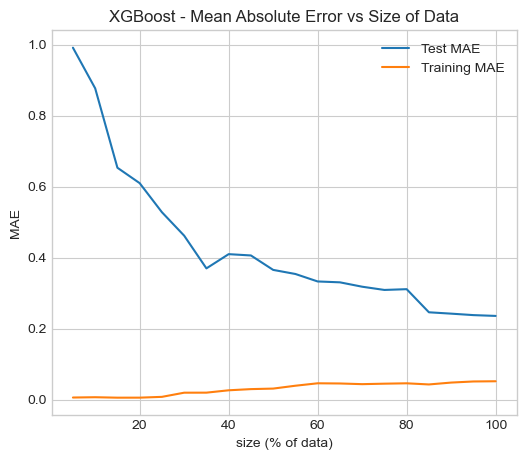

In [28]:
# results_xgb is organized as ['Training score', 'Test score', 'size (% of data)']
train_mae_by_size = results_xgb[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results_xgb[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results_xgb[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("XGBoost - Mean Absolute Error vs Size of Data")

In [29]:
# Collect and print out final results
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)

new_results = pd.DataFrame({"Model": 'XGBoost',
                            "Train Error": [train_mae_raw],
                            "Train Error %": [train_mae_pct],
                            "Test Error": [test_mae_raw],
                            "Test Error %": [test_mae_pct]})

results_compare = pd.concat([results_compare, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.23610627406147028
Mean of Test results: 1.491652465677596
Percent Error on Test mean: 15.8%

Final MAE on Training results: 0.05216063281773804
Mean of Training results: 1.5308428581540567
Percent Error on Training mean: 3.4%


### KNN

Note that KNN only has 1 hyperparameter, so no need to do a full GridSearchCV. We can just plot performance manually

In [30]:
def get_KNN_CV_score(X, y, n_neighbors):
  """Return the average MAE over 5 CV folds of KNN model.

  Keyword argument:
  X -- training data
  y -- training results
  n_neighbors -- number of neighbors
  """

  my_pipeline = Pipeline(steps=[
    ('model', KNeighborsRegressor(n_neighbors=n_neighbors))
  ])

  scores = cross_validate(my_pipeline, X, y,
                                cv=5, scoring=('r2', 'neg_mean_absolute_error'),
                                return_train_score=True)

  return [-1*np.mean(scores['test_neg_mean_absolute_error']), -1*np.mean(scores['train_neg_mean_absolute_error'])]

In [31]:
results = {i: get_KNN_CV_score(X_train, y_train, i) for i in range(1, 10)} # Previously tried 100 but graph too big

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


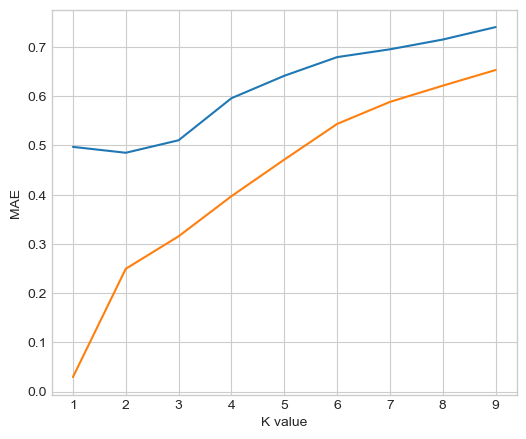

In [32]:
plt.plot(list(results.keys()), list(results.values()))
plt.xlabel('K value')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [33]:
results = data_size_tester(X_train, y_train, X_test, y_test, KNeighborsRegressor(n_neighbors=2))

Text(0.5, 1.0, 'KNN - Mean Absolute Error vs Size of Data')

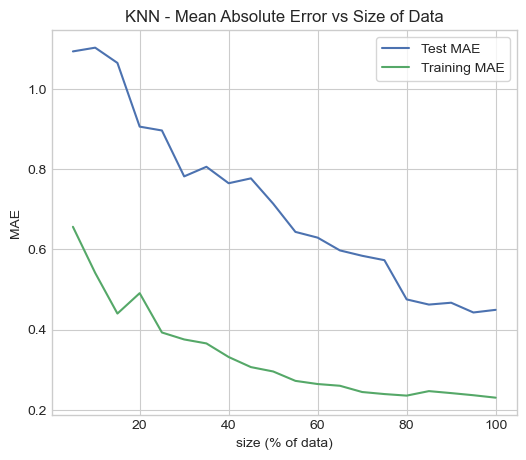

In [34]:
train_mae_by_size = results[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size,"#4c72b0", label="Test MAE")
plt.plot(tested_size,train_mae_by_size, "#55a868",label = "Training MAE")
plt.legend(frameon=True)
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("KNN - Mean Absolute Error vs Size of Data")

In [35]:
# Collect and print out final results
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)

new_results = pd.DataFrame({"Model": 'K-Nearest Neighbours',
                            "Train Error": [train_mae_raw],
                            "Train Error %": [train_mae_pct],
                            "Test Error": [test_mae_raw],
                            "Test Error %": [test_mae_pct]})

results_compare = pd.concat([results_compare, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.4496952611147541
Mean of Test results: 1.491652465677596
Percent Error on Test mean: 30.1%

Final MAE on Training results: 0.23094526796011003
Mean of Training results: 1.5308428581540567
Percent Error on Training mean: 15.1%


### Multiple Regression

In [36]:
# MLR can be performed directly
results = data_size_tester(X_train, y_train, X_test, y_test, LinearRegression())

Text(0.5, 1.0, 'MLR - Mean Absolute Error vs Size of Data')

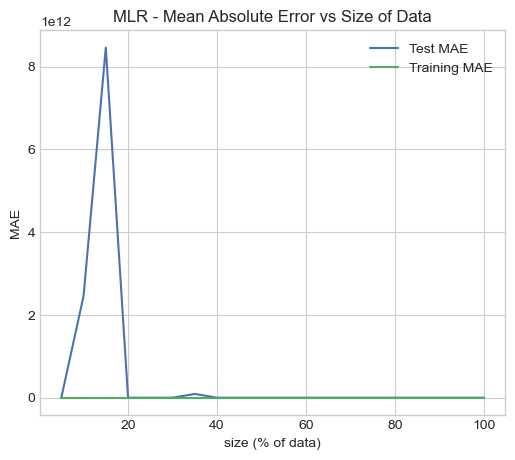

In [37]:
train_mae_by_size = results[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size,"#4c72b0", label="Test MAE")
plt.plot(tested_size,train_mae_by_size, "#55a868",label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("MLR - Mean Absolute Error vs Size of Data")

In [38]:
# Collect and print out final results
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)

new_results = pd.DataFrame({"Model": 'Multiple Linear Regression',
                            "Train Error": [train_mae_raw],
                            "Train Error %": [train_mae_pct],
                            "Test Error": [test_mae_raw],
                            "Test Error %": [test_mae_pct]})

results_compare = pd.concat([results_compare, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.9589043970276747
Mean of Test results: 1.491652465677596
Percent Error on Test mean: 64.3%

Final MAE on Training results: 0.9314756812785474
Mean of Training results: 1.5308428581540567
Percent Error on Training mean: 60.8%


### Support Vector Regression

In [39]:
# Define the pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])

param_grid = {
    'svr__kernel': ['rbf', 'linear', 'poly'],
    'svr__C': [0.1, 1, 10, 20],
    'svr__gamma': [0.01, 0.1, 1],
    'svr__epsilon': [0.01, 0.05, 0.1, 1]# Adjust for chosen kernel
}

In [40]:
# Using pipeline
gssvr = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-3)
gssvr.fit(X_train, y_train)

# print best parameter after tuning
print(gssvr.best_params_)

{'svr__C': 10, 'svr__epsilon': 0.05, 'svr__gamma': 0.1, 'svr__kernel': 'poly'}


In [41]:
# {'svr__C': 10, 'svr__epsilon': 0.05, 'svr__gamma': 0.1, 'svr__kernel': 'poly'} : Optimized

krnl = gssvr.best_params_['svr__kernel']
regu = gssvr.best_params_['svr__C']
gamma = gssvr.best_params_['svr__gamma']
epsilon = gssvr.best_params_['svr__epsilon']

In [42]:
svr_model = make_pipeline(StandardScaler(), SVR(C=regu, gamma=gamma, kernel=krnl, epsilon=epsilon))
#svr_model = make_pipeline(StandardScaler(), SVR(C=10, epsilon=0.05, gamma=0.1, kernel='poly'))

results = data_size_tester(X_train, y_train, X_test, y_test, svr_model)


Text(0.5, 1.0, 'SVR - Mean Absolute Error vs Size of Data')

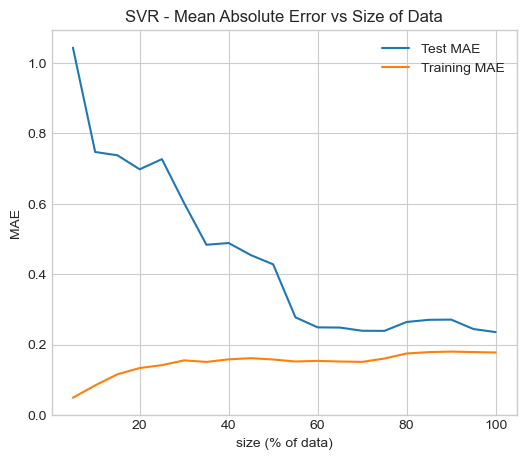

In [43]:
train_mae_by_size = results[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("SVR - Mean Absolute Error vs Size of Data")

In [44]:
# Collect and print out final results
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)

new_results = pd.DataFrame({"Model": 'Support Vector Regression',
                            "Train Error": [train_mae_raw],
                            "Train Error %": [train_mae_pct],
                            "Test Error": [test_mae_raw],
                            "Test Error %": [test_mae_pct]})

results_compare = pd.concat([results_compare, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.23552339701832078
Mean of Test results: 1.491652465677596
Percent Error on Test mean: 15.8%

Final MAE on Training results: 0.17760320275080727
Mean of Training results: 1.5308428581540567
Percent Error on Training mean: 11.6%


In [45]:
# Creating the SVR XGB comparison graph

results_svr = data_size_tester(X_train, y_train, X_test, y_test, svr_model)
results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.13, n_estimators=300))

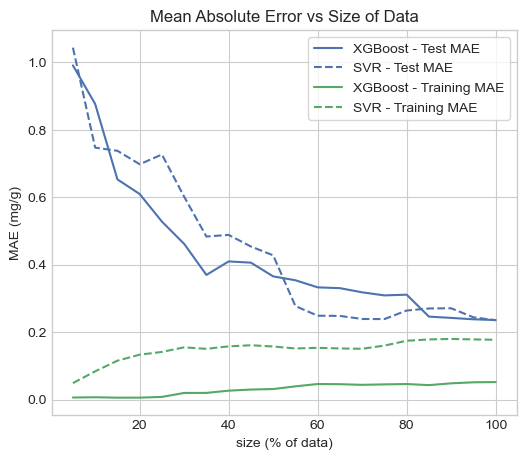

In [46]:
train_mae_by_size_svr = results_svr[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size_svr = results_svr[:, [1]] #Validation MAE that these different sizes of data yield

train_mae_by_size_xgb = results_xgb[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size_xgb = results_xgb[:, [1]] #Validation MAE that these different sizes of data yield

tested_size = results[:, [2]]

rcParams['figure.figsize']=6,5

#palette = sns.color_palette(["#4c72b0","#4c72b0","#55a868","#55a868"])
plt.plot(tested_size,test_mae_by_size_xgb, "#4c72b0", label="XGBoost - Test MAE")
plt.plot(tested_size,test_mae_by_size_svr, "#4c72b0", linestyle='dashed', label="SVR - Test MAE")
plt.plot(tested_size,train_mae_by_size_xgb, "#55a868", label = "XGBoost - Training MAE")
plt.plot(tested_size,train_mae_by_size_svr, "#55a868", linestyle='dashed', label = "SVR - Training MAE")
plt.legend(frameon=True)
plt.xlabel('size (% of data)')
plt.ylabel('MAE (mg/g)')
plt.title("Mean Absolute Error vs Size of Data")

plt.savefig("figure_2.pdf", format="pdf")
plt.show()

### Neural Net

In [47]:
parameters = {'hidden_layer_sizes':[(50 * i, 25*i, int(12.5*i)) for i in range(2, 8)], 
              'learning_rate_init':[0.000125 * i for i in range(1, 15)], 'max_iter':[100 * i for i in range(1, 6)]}

GridSearch_model = MLPRegressor()
mlpr = GridSearchCV(GridSearch_model, parameters, verbose=1, n_jobs=-3)
mlpr.fit(X_train, y_train)

# print best parameter after tuning
print(mlpr.best_params_)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
{'hidden_layer_sizes': (300, 150, 75), 'learning_rate_init': 0.0016250000000000001, 'max_iter': 200}


In [48]:
# {'hidden_layer_sizes': (300, 150, 75), 'learning_rate_init': 0.001625, 'max_iter': 200} : Optimized

hid_sizes = mlpr.best_params_['hidden_layer_sizes']
lr_init = mlpr.best_params_['learning_rate_init']
max_iter = mlpr.best_params_['max_iter']

In [49]:
results = data_size_tester(X_train, y_train, X_test, y_test, MLPRegressor(hidden_layer_sizes=hid_sizes,
                                                                          learning_rate_init=lr_init,
                                                                          max_iter=max_iter))

#results = data_size_tester(X_train, y_train, X_test, y_test, MLPRegressor(hidden_layer_sizes=(300, 150, 75),
#                                                                          learning_rate_init=0.001625,
#                                                                          max_iter=200))


C:\Development\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Development\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Development\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Development\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Text(0.5, 1.0, 'NN - Mean Absolute Error vs Size of Data')

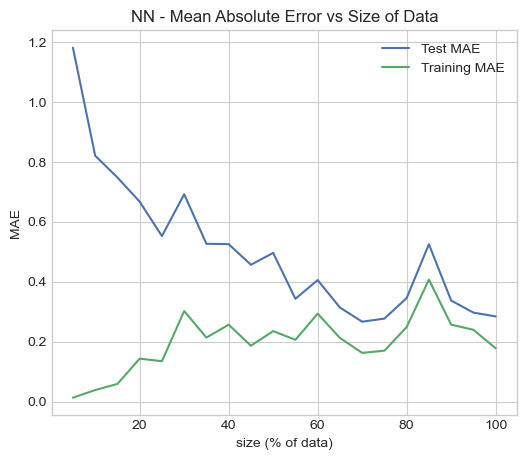

In [50]:
train_mae_by_size = results[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size,"#4c72b0", label="Test MAE")
plt.plot(tested_size,train_mae_by_size, "#55a868",label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("NN - Mean Absolute Error vs Size of Data")

In [51]:
# Collect and print out final results
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)

new_results = pd.DataFrame({"Model": 'Neural Networks',
                            "Train Error": [train_mae_raw],
                            "Train Error %": [train_mae_pct],
                            "Test Error": [test_mae_raw],
                            "Test Error %": [test_mae_pct]})

results_compare = pd.concat([results_compare, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.2841929782663799
Mean of Test results: 1.491652465677596
Percent Error on Test mean: 19.1%

Final MAE on Training results: 0.17785859524818126
Mean of Training results: 1.5308428581540567
Percent Error on Training mean: 11.6%


### DT

In [52]:
parameters = {'max_depth':[ i for i in range(1, 41)], 'min_samples_split':[i for i in range(2, 25)]}

GridSearch_model = DecisionTreeRegressor()
dtr = GridSearchCV(GridSearch_model, parameters)
dtr.fit(X_train, y_train)

# print best parameter after tuning
print(dtr.best_params_)

{'max_depth': 33, 'min_samples_split': 10}


In [53]:
# {'max_depth': 33, 'min_samples_split': 10} : Optimized

m_depth = dtr.best_params_['max_depth']
min_split = dtr.best_params_['min_samples_split']

In [54]:
results = data_size_tester(X_train, y_train, X_test, y_test, DecisionTreeRegressor(max_depth=m_depth,
                                                                                   min_samples_split=min_split))

#results = data_size_tester(X_train, y_train, X_test, y_test, DecisionTreeRegressor(max_depth=33,
#                                                                                 min_samples_split=10))


Text(0.5, 1.0, 'DT - Mean Absolute Error vs Size of Data')

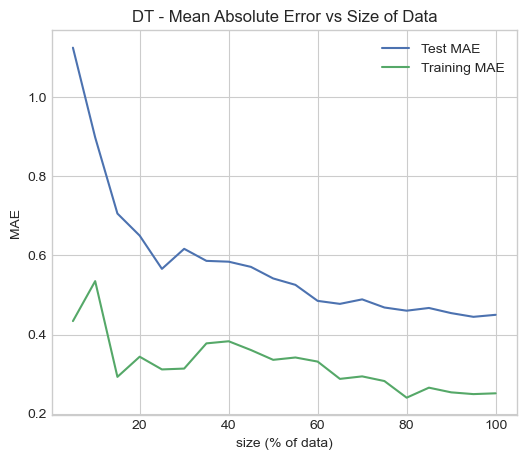

In [55]:
train_mae_by_size = results[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size,"#4c72b0", label="Test MAE")
plt.plot(tested_size,train_mae_by_size, "#55a868",label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("DT - Mean Absolute Error vs Size of Data")

In [56]:
# Collect and print out final results
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)

new_results = pd.DataFrame({"Model": 'Decision Trees',
                            "Train Error": [train_mae_raw],
                            "Train Error %": [train_mae_pct],
                            "Test Error": [test_mae_raw],
                            "Test Error %": [test_mae_pct]})

results_compare = pd.concat([results_compare, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.44980479634394355
Mean of Test results: 1.491652465677596
Percent Error on Test mean: 30.2%

Final MAE on Training results: 0.2515548618196393
Mean of Training results: 1.5308428581540567
Percent Error on Training mean: 16.4%


### RF

In [57]:
parameters = {'n_estimators':[i for i in range(1, 61)], 'max_depth':[ i for i in range(1, 26)]}

GridSearch_model = RandomForestRegressor()
rfr = GridSearchCV(GridSearch_model, parameters,n_jobs=-3)
rfr.fit(X_train, y_train)

# print best parameter after tuning
print(rfr.best_params_)

{'max_depth': 18, 'n_estimators': 7}


In [58]:
# {'max_depth': 18, 'n_estimators': 7} : Optimized

m_depth = rfr.best_params_['max_depth']
n_est = rfr.best_params_['n_estimators']

In [59]:
results = data_size_tester(X_train, y_train, X_test, y_test, RandomForestRegressor(max_depth=m_depth, n_estimators=n_est))
#results = data_size_tester(X_train, y_train, X_test, y_test, RandomForestRegressor(max_depth=18, n_estimators=7))

Text(0.5, 1.0, 'RF - Mean Absolute Error vs Size of Data')

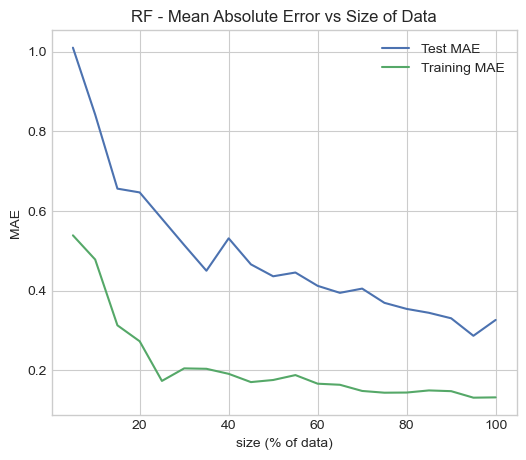

In [60]:
train_mae_by_size = results[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size,"#4c72b0", label="Test MAE")
plt.plot(tested_size,train_mae_by_size, "#55a868",label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("RF - Mean Absolute Error vs Size of Data")

In [61]:
# Collect and print out final results
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)

new_results = pd.DataFrame({"Model": 'Random Forest',
                            "Train Error": [train_mae_raw],
                            "Train Error %": [train_mae_pct],
                            "Test Error": [test_mae_raw],
                            "Test Error %": [test_mae_pct]})

results_compare = pd.concat([results_compare, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.32643155264639345
Mean of Test results: 1.491652465677596
Percent Error on Test mean: 21.9%

Final MAE on Training results: 0.13196625204181844
Mean of Training results: 1.5308428581540567
Percent Error on Training mean: 8.6%


### All results

In [62]:
results_compare.sort_values(by="Test Error %")

,Model,Train Error,Train Error %,Test Error,Test Error %
0,XGBoost,0.052161,3.4,0.236106,15.8
3,Support Vector Regression,0.177603,11.6,0.235523,15.8
4,Neural Networks,0.177859,11.6,0.284193,19.1
6,Random Forest,0.131966,8.6,0.326432,21.9
1,K-Nearest Neighbours,0.230945,15.1,0.449695,30.1
5,Decision Trees,0.251555,16.4,0.449805,30.2
2,Multiple Linear Regression,0.931476,60.8,0.958904,64.3


# 3.2.2 - Testing on complete SPE database

Note that we are no longer using feature scaling in this section, as this is not necessary for XGBoost.

## Scenario 1 tests

In [63]:
# Create an array to hold the test results, starting with Scenario 1

results_compare = pd.DataFrame(columns=['Test set', 'Scenario 1 - Train Error %', 'Scenario 1 - Test Error %'])

### Main model

In [64]:
# Strip out the erosion rates and set them as y
y = data_names_only['Erosion Rate (mg/g)']
X = data_names_only.drop(columns='Erosion Rate (mg/g)')

# Do one-hot encoding for categorical variables
X = pd.get_dummies(X)

X.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Eroded Material_Al,Eroded Material_Al - 1100-O,Eroded Material_Al - 2024,...,Erodent_Quartz,Erodent_SiC,Erodent_SiO2,Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel
count,922.000000,922.000000,910.000000,536.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,148.359490,135.985535,52.063736,6.310082,78.024946,0.175705,1992.761388,0.104121,0.022777,0.048807,...,0.134490,0.246204,0.225597,0.854664,0.036876,0.844902,0.062907,0.814534,0.127983,0.057484
std,102.085206,87.332032,28.686238,6.976491,140.701718,0.380776,22.008722,0.305584,0.149271,0.215581,...,0.341363,0.431033,0.418201,0.352631,0.188560,0.362194,0.242927,0.388886,0.334252,0.232891
min,7.730000,10.000000,3.000000,0.760000,-7.000000,0.000000,1960.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,74.000000,30.000000,3.750000,21.000000,0.000000,1970.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,127.000000,108.000000,45.000000,5.000000,21.000000,0.000000,1995.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,210.000000,152.000000,90.000000,7.400000,21.000000,0.000000,2014.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,490.000000,554.000000,90.000000,50.000000,800.000000,1.000000,2023.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
# Find a random state for splitting which gives a split with less than 5% difference in the y values
# Use 80% of data for training and 20% for test.
er_ratio = 0

i=-1
while not 0.95 <= er_ratio <= 1.05:
    i += 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
    er_ratio = y_train.mean()/y_test.mean()

print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")
print(f"Train/Test Erosion rate ratio: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")

Mean of Training results: 1.5105242016336489
Mean of Test results: 1.475907095691892
Train/Test Erosion rate ratio: 1.0234548001312567
random_state: 1


In [66]:
# Reoptimized XGBoost for the current dataset
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
clf = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
clf.fit(X_train, y_train)

# print best parameter after tuning
print(clf.best_params_)

{'learning_rate': 0.13, 'n_estimators': 300}


In [67]:
# {'learning_rate': 0.13, 'n_estimators': 300} : Optimized

n_est = clf.best_params_['n_estimators']
lr = clf.best_params_['learning_rate']

In [68]:
results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=lr, n_estimators=n_est))
#results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.13, n_estimators=300))

Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

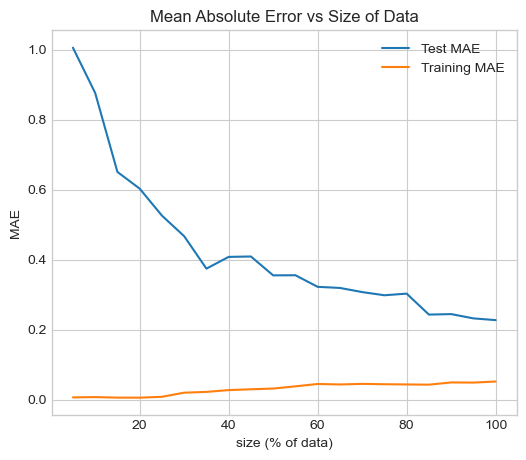

In [69]:
train_mae_by_size = results_xgb[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results_xgb[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results_xgb[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [70]:
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)


new_results = pd.DataFrame({"Test set": 'Main model',
                            "Scenario 1 - Train Error %": [train_mae_pct],
                            "Scenario 1 - Test Error %": [test_mae_pct]})

results_compare = pd.concat([results_compare, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.22722569591068967
Mean of Test results: 1.475907095691892
Percent Error on Test mean: 15.4%

Final MAE on Training results: 0.05171214999632275
Mean of Training results: 1.5105242016336489
Percent Error on Training mean: 3.4%


#### Residuals

In [71]:
# Make a model with the optimized hyperparameters to calculate residuals on the test data
model = XGBRegressor(learning_rate=0.13, n_estimators=300)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test_np = y_test.to_numpy()

# Use the previously defined MAE % results for spread lines
mae_spread = round(test_mae_pct/100,3)


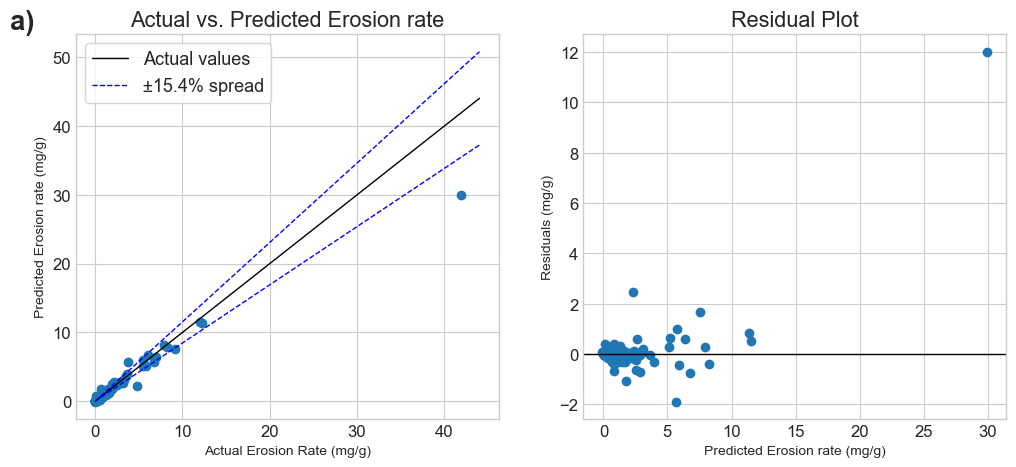

In [72]:
# Plot residuals
fig, axs = plt.subplots(1, 2, figsize=(12,5))

plt.rc('font', size=13)

# Plot actual vs predicted
axs[0].scatter(y_test_np, y_pred)
axs[0].set_xlabel('Actual Erosion Rate (mg/g)')
axs[0].set_ylabel('Predicted Erosion rate (mg/g)')
axs[0].set_title('Actual vs. Predicted Erosion rate')

# Get the current axes limits for plotting y = x line
xlims = axs[0].get_xlim()
ylims = axs[0].get_ylim()
min_val = min(xlims[0], ylims[0])
max_val = max(xlims[1], ylims[1])

# Plot the y=x line
axs[0].plot([0, max_val], [0, max_val], 'k', linewidth=1, label="Actual values")
# Plot the spread lines
axs[0].plot([0, max_val], [(1+mae_spread)*0, (1+mae_spread)*max_val], 'b--', linewidth=1, label=f"±{100*mae_spread}% spread")
axs[0].plot([0, max_val], [(1-mae_spread)*0, (1-mae_spread)*max_val], 'b--', linewidth=1)
axs[0].legend(frameon=True)

# Plot residuals
residuals = y_test_np - y_pred
axs[1].scatter(y_pred, residuals)
axs[1].set_xlabel('Predicted Erosion rate (mg/g)')
axs[1].set_ylabel('Residuals (mg/g)')
axs[1].set_title('Residual Plot')
plt.axhline(y=0, color='k', linewidth=1)

fig.text(0.07, 0.93, 'a)', fontsize=20, fontweight='bold', va='top')

# Change tick label size
axs[0].tick_params(axis='both', labelsize=12)
axs[1].tick_params(axis='both', labelsize=12)

plt.savefig("figure_3a.png", dpi=500, format="png")
plt.show()


In [73]:
test_value = test_mae_pct
percentage = percentage_within_error(y_test_np, y_pred, 0.01*test_value)
print(f"Percentage within {test_value}% error: {percentage:.2f}%")


Percentage within 15.4% error: 56.22%


### XGB - SiO2 == ARD == Quartz

In [74]:
print(f"There are {X['Erodent_Arizona Road Dust'].sum()} instances where erodent is ARD, "
      f"{X['Erodent_SiO2'].sum()} instances where erodent is SiO2, "
      f"and {X['Erodent_Quartz'].sum()} instances where erodent is Quartz.")

There are 128 instances where erodent is ARD, 208 instances where erodent is SiO2, and 124 instances where erodent is Quartz.


In [75]:
# Call all of these SiO2 for simplicity
data_names_only_SiO2 = data_names_only.replace({'Erodent':{'Arizona Road Dust':'SiO2'}})
data_names_only_SiO2 = data_names_only_SiO2.replace({'Erodent':{'Quartz':'SiO2'}})

# Strip out the erosion rates and set them as y
y = data_names_only_SiO2['Erosion Rate (mg/g)']
X = data_names_only_SiO2.drop(columns='Erosion Rate (mg/g)')

# Do OneHot encoding
X = pd.get_dummies(X)

X.head()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Eroded Material_Al,Eroded Material_Al - 1100-O,Eroded Material_Al - 2024,...,Erodent_Glass,Erodent_SiC,Erodent_SiO2,Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel
0,125.0,65.0,30.0,3.0,21,0,1995,0,0,0,...,0,1,0,1,0,1,0,1,0,0
1,125.0,65.0,30.0,3.0,100,0,1995,0,0,0,...,0,1,0,1,0,1,0,1,0,0
2,125.0,65.0,30.0,3.0,200,0,1995,0,0,0,...,0,1,0,1,0,1,0,1,0,0
3,125.0,65.0,30.0,3.0,300,0,1995,0,0,0,...,0,1,0,1,0,1,0,1,0,0
4,125.0,65.0,30.0,3.0,400,0,1995,0,0,0,...,0,1,0,1,0,1,0,1,0,0


In [76]:
# Find a random state for splitting which gives a split with less than 5% difference in the y values
# Use 80% of data for training and 20% for test.
er_ratio = 0

i=-1
while not 0.95 <= er_ratio <= 1.05:
    i += 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
    er_ratio = y_train.mean()/y_test.mean()

print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")
print(f"Train/Test Erosion rate ratio: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")

Mean of Training results: 1.5105242016336489
Mean of Test results: 1.475907095691892
Train/Test Erosion rate ratio: 1.0234548001312567
random_state: 1


In [77]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
clf = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
clf.fit(X_train, y_train)

# print best parameter after tuning
print(clf.best_params_)

{'learning_rate': 0.13, 'n_estimators': 300}


In [78]:
#  {'learning_rate': 0.13, 'n_estimators': 300} : Optimized

n_est = clf.best_params_['n_estimators']
lr = clf.best_params_['learning_rate']

In [79]:
results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=lr, n_estimators=n_est))
#results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.13, n_estimators=300))


Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

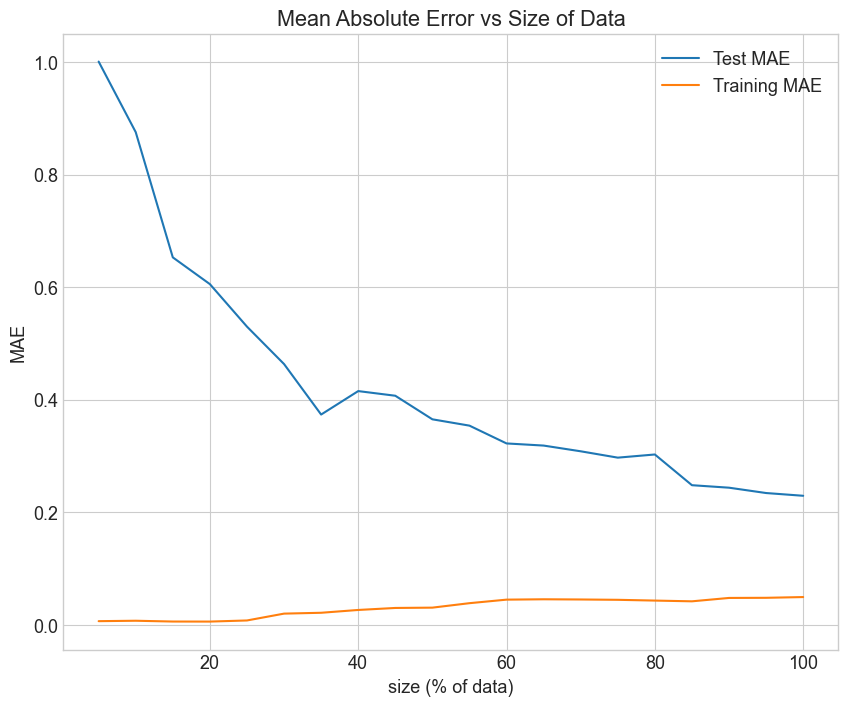

In [80]:
train_mae_by_size = results_xgb[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results_xgb[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results_xgb[:, [2]]

rcParams['figure.figsize']=10,8
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [81]:
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)


new_results = pd.DataFrame({"Test set": 'SiO2 == ARD == Quartz',
                            "Scenario 1 - Train Error %": [train_mae_pct],
                            "Scenario 1 - Test Error %": [test_mae_pct]})

results_compare = pd.concat([results_compare, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.2293036637490778
Mean of Test results: 1.475907095691892
Percent Error on Test mean: 15.5%

Final MAE on Training results: 0.049273870580363234
Mean of Training results: 1.5105242016336489
Percent Error on Training mean: 3.3%


### XGB - Room Temperature Only

In [82]:
# Strip out the erosion rates and set them as y
y = data_names_only['Erosion Rate (mg/g)']
X = data_names_only.drop(columns='Erosion Rate (mg/g)')

# Do one-hot encoding for categorical variables (Only erodent type to begin)
X = pd.get_dummies(X)

X.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Eroded Material_Al,Eroded Material_Al - 1100-O,Eroded Material_Al - 2024,...,Erodent_Quartz,Erodent_SiC,Erodent_SiO2,Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel
count,922.000000,922.000000,910.000000,536.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,148.359490,135.985535,52.063736,6.310082,78.024946,0.175705,1992.761388,0.104121,0.022777,0.048807,...,0.134490,0.246204,0.225597,0.854664,0.036876,0.844902,0.062907,0.814534,0.127983,0.057484
std,102.085206,87.332032,28.686238,6.976491,140.701718,0.380776,22.008722,0.305584,0.149271,0.215581,...,0.341363,0.431033,0.418201,0.352631,0.188560,0.362194,0.242927,0.388886,0.334252,0.232891
min,7.730000,10.000000,3.000000,0.760000,-7.000000,0.000000,1960.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,74.000000,30.000000,3.750000,21.000000,0.000000,1970.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,127.000000,108.000000,45.000000,5.000000,21.000000,0.000000,1995.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,210.000000,152.000000,90.000000,7.400000,21.000000,0.000000,2014.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,490.000000,554.000000,90.000000,50.000000,800.000000,1.000000,2023.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [83]:
# Find a random state for splitting which gives a split with less than 5% difference in the y values
# Use 80% of data for training and 20% for test.
er_ratio = 0

i=-1
while not 0.95 <= er_ratio <= 1.05:
    i += 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
    er_ratio = y_train.mean()/y_test.mean()

print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")
print(f"Train/Test Erosion rate ratio: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")

Mean of Training results: 1.5105242016336489
Mean of Test results: 1.475907095691892
Train/Test Erosion rate ratio: 1.0234548001312567
random_state: 1


In [84]:
# Sanity check part 1
X_train_sanity = X_train.join(y_train)
X_test_sanity = X_test.join(y_test)
print('Before values for RT only:')
print(f"Mean of Training results: {X_train_sanity[X_train_sanity['Temperature (°C)'] < 31]['Erosion Rate (mg/g)'].mean()}")
print(f"Mean of Test results: {X_test_sanity[X_test_sanity['Temperature (°C)'] < 31]['Erosion Rate (mg/g)'].mean()}\n")

# Put training and test data/y back together to remove high temperature data
all_train = X_train.join(y_train)
all_test = X_test.join(y_test)

all_train = all_train[all_train['Temperature (°C)'] < 31]
all_test = all_test[all_test['Temperature (°C)'] < 31]

# Split everything back up
y_train = all_train['Erosion Rate (mg/g)']
X_train = all_train.drop(columns='Erosion Rate (mg/g)')

y_test = all_test['Erosion Rate (mg/g)']
X_test = all_test.drop(columns='Erosion Rate (mg/g)')

# Sanity check that splits are still the same
print('After values for RT only:')
print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")


Before values for RT only:
Mean of Training results: 1.7303295567181196
Mean of Test results: 1.6710991026339872

After values for RT only:
Mean of Training results: 1.7303295567181196
Mean of Test results: 1.6710991026339872


In [85]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
clf = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
clf.fit(X_train, y_train)

# print best parameter after tuning
print(clf.best_params_)

{'learning_rate': 0.13, 'n_estimators': 200}


In [86]:
# {'learning_rate': 0.13, 'n_estimators': 200} : Optimized

n_est = clf.best_params_['n_estimators']
lr = clf.best_params_['learning_rate']

In [87]:
results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=lr, n_estimators=n_est))
#results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.13, n_estimators=200))

Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

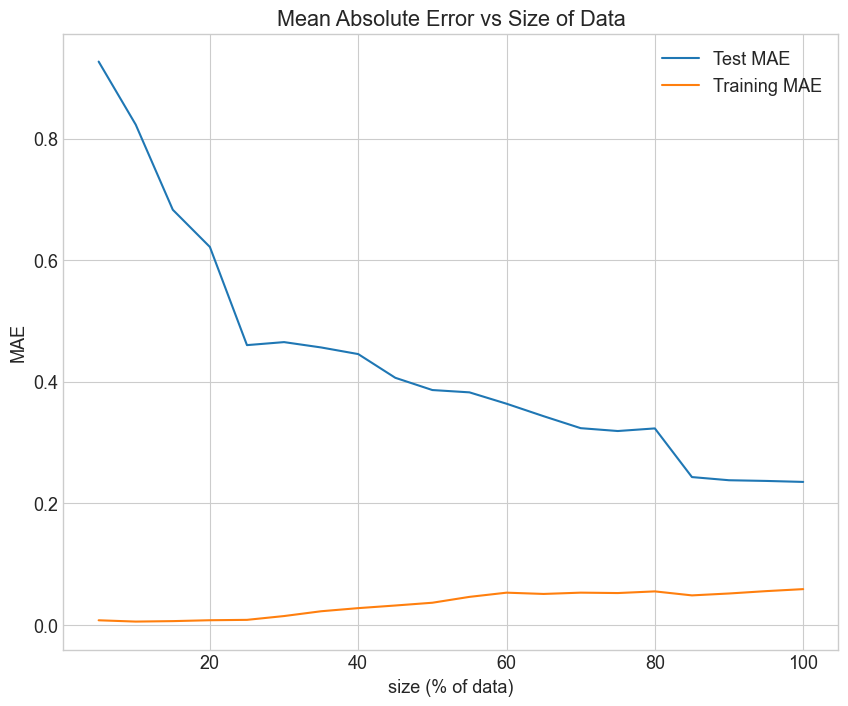

In [88]:
train_mae_by_size = results_xgb[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results_xgb[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results_xgb[:, [2]]

rcParams['figure.figsize']=10,8
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [89]:
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)


new_results = pd.DataFrame({"Test set": 'RT Only',
                            "Scenario 1 - Train Error %": [train_mae_pct],
                            "Scenario 1 - Test Error %": [test_mae_pct]})

results_compare = pd.concat([results_compare, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.2351456960167179
Mean of Test results: 1.6710991026339872
Percent Error on Test mean: 14.1%

Final MAE on Training results: 0.058766107803103235
Mean of Training results: 1.7303295567181196
Percent Error on Training mean: 3.4%


### XGB - High Temperature Only

In [90]:
# Strip out the erosion rates and set them as y
y = data_names_only['Erosion Rate (mg/g)']
X = data_names_only.drop(columns='Erosion Rate (mg/g)')

# Do one-hot encoding for categorical variables (Only erodent type to begin)
X = pd.get_dummies(X)

X.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Eroded Material_Al,Eroded Material_Al - 1100-O,Eroded Material_Al - 2024,...,Erodent_Quartz,Erodent_SiC,Erodent_SiO2,Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel
count,922.000000,922.000000,910.000000,536.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,148.359490,135.985535,52.063736,6.310082,78.024946,0.175705,1992.761388,0.104121,0.022777,0.048807,...,0.134490,0.246204,0.225597,0.854664,0.036876,0.844902,0.062907,0.814534,0.127983,0.057484
std,102.085206,87.332032,28.686238,6.976491,140.701718,0.380776,22.008722,0.305584,0.149271,0.215581,...,0.341363,0.431033,0.418201,0.352631,0.188560,0.362194,0.242927,0.388886,0.334252,0.232891
min,7.730000,10.000000,3.000000,0.760000,-7.000000,0.000000,1960.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,74.000000,30.000000,3.750000,21.000000,0.000000,1970.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,127.000000,108.000000,45.000000,5.000000,21.000000,0.000000,1995.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,210.000000,152.000000,90.000000,7.400000,21.000000,0.000000,2014.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,490.000000,554.000000,90.000000,50.000000,800.000000,1.000000,2023.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
# Find a random state for splitting which gives a split with less than 5% difference in the y values
# Use 80% of data for training and 20% for test.
er_ratio = 0

i=-1
while not 0.95 <= er_ratio <= 1.05:
    i += 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
    er_ratio = y_train.mean()/y_test.mean()

print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")
print(f"Train/Test Erosion rate ratio: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")

Mean of Training results: 1.5105242016336489
Mean of Test results: 1.475907095691892
Train/Test Erosion rate ratio: 1.0234548001312567
random_state: 1


In [92]:
# Sanity check part 1
X_train_sanity = X_train.join(y_train)
X_test_sanity = X_test.join(y_test)
print('Before values for HT only:')
print(f"Mean of Training results: {X_train_sanity[X_train_sanity['Temperature (°C)'] > 31]['Erosion Rate (mg/g)'].mean()}")
print(f"Mean of Test results: {X_test_sanity[X_test_sanity['Temperature (°C)'] > 31]['Erosion Rate (mg/g)'].mean()}\n")

# Put training and test data/y back together to remove room temperature data
all_train = X_train.join(y_train)
all_test = X_test.join(y_test)

all_train = all_train[all_train['Temperature (°C)'] > 31]
all_test = all_test[all_test['Temperature (°C)'] > 31]

# Split everything back up
y_train = all_train['Erosion Rate (mg/g)']
X_train = all_train.drop(columns='Erosion Rate (mg/g)')

y_test = all_test['Erosion Rate (mg/g)']
X_test = all_test.drop(columns='Erosion Rate (mg/g)')

# Sanity check that splits are still the same
print('After values for HT only:')
print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")


Before values for HT only:
Mean of Training results: 0.5814178780141845
Mean of Test results: 0.5426453125

After values for HT only:
Mean of Training results: 0.5814178780141845
Mean of Test results: 0.5426453125


In [93]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
clf = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
clf.fit(X_train, y_train)

# print best parameter after tuning
print(clf.best_params_)

{'learning_rate': 0.23, 'n_estimators': 50}


In [94]:
# {'learning_rate': 0.23, 'n_estimators': 50} : Optimized

n_est = clf.best_params_['n_estimators']
lr = clf.best_params_['learning_rate']

In [95]:
results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=lr, n_estimators=n_est))
#results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.23, n_estimators=50))

Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

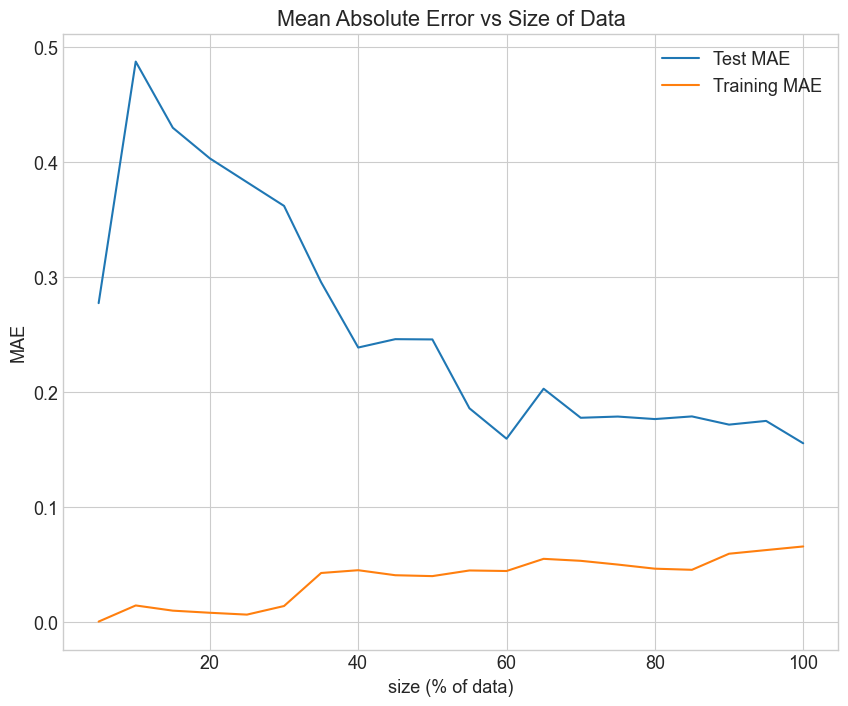

In [96]:
train_mae_by_size = results_xgb[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results_xgb[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results_xgb[:, [2]]

rcParams['figure.figsize']=10,8
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [97]:
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)


new_results = pd.DataFrame({"Test set": 'HT Only',
                            "Scenario 1 - Train Error %": [train_mae_pct],
                            "Scenario 1 - Test Error %": [test_mae_pct]})

results_compare = pd.concat([results_compare, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.15552822793209925
Mean of Test results: 0.5426453125
Percent Error on Test mean: 28.7%

Final MAE on Training results: 0.06585339439210383
Mean of Training results: 0.5814178780141845
Percent Error on Training mean: 11.3%


In [98]:
results_compare

,Test set,Scenario 1 - Train Error %,Scenario 1 - Test Error %
0,Main model,3.4,15.4
1,SiO2 == ARD == Quartz,3.3,15.5
2,RT Only,3.4,14.1
3,HT Only,11.3,28.7


## Scenario 2 tests

In [99]:
# Create an array to hold the test results, to be added to previous

results_compare_2 = pd.DataFrame(columns=['Test set', 'Scenario 2 - Train Error %', 'Scenario 2 - Test Error %'])

### Main model

In [100]:
# Strip out the erosion rates and set them as y
y = data_base_names['Erosion Rate (mg/g)']
X = data_base_names.drop(columns='Erosion Rate (mg/g)')

# Do one-hot encoding for categorical variables (erodent type, shape, carrier gas)
X = pd.get_dummies(X)

X.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Eroded Material_Al,Eroded Material_Cu,Eroded Material_Fe,...,Erodent_Quartz,Erodent_SiC,Erodent_SiO2,Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel
count,922.000000,922.000000,910.000000,536.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,148.359490,135.985535,52.063736,6.310082,78.024946,0.175705,1992.761388,0.219089,0.009761,0.032538,...,0.134490,0.246204,0.225597,0.854664,0.036876,0.844902,0.062907,0.814534,0.127983,0.057484
std,102.085206,87.332032,28.686238,6.976491,140.701718,0.380776,22.008722,0.413854,0.098370,0.177520,...,0.341363,0.431033,0.418201,0.352631,0.188560,0.362194,0.242927,0.388886,0.334252,0.232891
min,7.730000,10.000000,3.000000,0.760000,-7.000000,0.000000,1960.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,74.000000,30.000000,3.750000,21.000000,0.000000,1970.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,127.000000,108.000000,45.000000,5.000000,21.000000,0.000000,1995.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,210.000000,152.000000,90.000000,7.400000,21.000000,0.000000,2014.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,490.000000,554.000000,90.000000,50.000000,800.000000,1.000000,2023.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [101]:
# Find a random state for splitting which gives a split with less than 5% difference in the y values
# Use 80% of data for training and 20% for test.
er_ratio = 0

i=-1
while not 0.95 <= er_ratio <= 1.05:
    i += 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
    er_ratio = y_train.mean()/y_test.mean()

print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")
print(f"Train/Test Erosion rate ratio: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")

Mean of Training results: 1.5105242016336489
Mean of Test results: 1.475907095691892
Train/Test Erosion rate ratio: 1.0234548001312567
random_state: 1


In [102]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
clf = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
clf.fit(X_train, y_train)

# print best parameter after tuning
print(clf.best_params_)

{'learning_rate': 0.13, 'n_estimators': 250}


In [103]:
# {'learning_rate': 0.13, 'n_estimators': 250} : Optimized

n_est = clf.best_params_['n_estimators']
lr = clf.best_params_['learning_rate']

In [104]:
results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=lr, n_estimators=n_est))
#results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.13, n_estimators=250))

Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

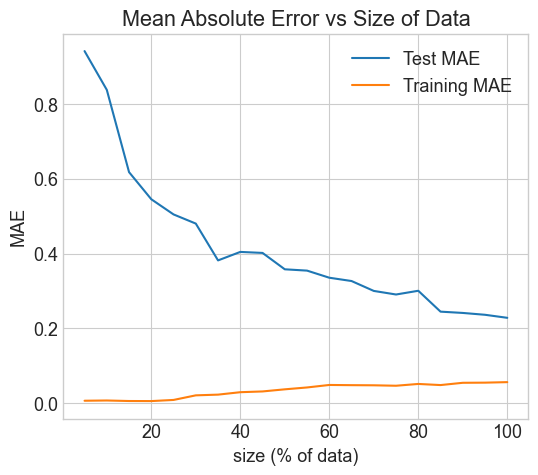

In [105]:
train_mae_by_size = results_xgb[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results_xgb[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results_xgb[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [106]:
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)


new_results = pd.DataFrame({"Test set": 'Main model',
                            "Scenario 2 - Train Error %": [train_mae_pct],
                            "Scenario 2 - Test Error %": [test_mae_pct]})

results_compare_2 = pd.concat([results_compare_2, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.2281020050858237
Mean of Test results: 1.475907095691892
Percent Error on Test mean: 15.5%

Final MAE on Training results: 0.05620913740273429
Mean of Training results: 1.5105242016336489
Percent Error on Training mean: 3.7%


#### Residuals

In [107]:
# Make a model with the optimized hyperparameters to calculated residuals on the test data
model = XGBRegressor(learning_rate=0.13, n_estimators=250)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test_np = y_test.to_numpy()

mae_spread = round(test_mae_pct/100,3)


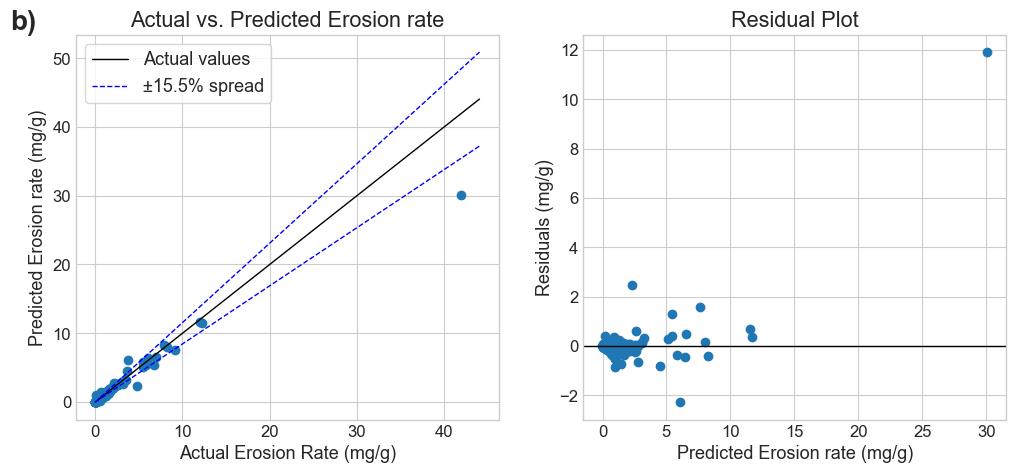

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

plt.rc('font', size=13)

# Plot actual vs predicted
axs[0].scatter(y_test_np, y_pred)
axs[0].set_xlabel('Actual Erosion Rate (mg/g)')
axs[0].set_ylabel('Predicted Erosion rate (mg/g)')
axs[0].set_title('Actual vs. Predicted Erosion rate')

# Get the current axes limits for plotting y = x line
xlims = axs[0].get_xlim()
ylims = axs[0].get_ylim()
min_val = min(xlims[0], ylims[0])
max_val = max(xlims[1], ylims[1])

# Plot the y=x line
axs[0].plot([0, max_val], [0, max_val], 'k', linewidth=1, label="Actual values")
# Plot the spread lines
axs[0].plot([0, max_val], [(1+mae_spread)*0, (1+mae_spread)*max_val], 'b--', linewidth=1, label=f"±{100*mae_spread}% spread")
axs[0].plot([0, max_val], [(1-mae_spread)*0, (1-mae_spread)*max_val], 'b--', linewidth=1)
axs[0].legend(frameon=True)

# Plot residuals
residuals = y_test_np - y_pred
axs[1].scatter(y_pred, residuals)
axs[1].set_xlabel('Predicted Erosion rate (mg/g)')
axs[1].set_ylabel('Residuals (mg/g)')
axs[1].set_title('Residual Plot')
plt.axhline(y=0, color='k', linewidth=1)

fig.text(0.07, 0.93, 'b)', fontsize=20, fontweight='bold', va='top')

# Change tick label size
axs[0].tick_params(axis='both', labelsize=12)
axs[1].tick_params(axis='both', labelsize=12)

plt.savefig("figure_3b.png", dpi=500, format="png")
plt.show()


In [109]:
# Use previously defined function for percentage within error

test_value = test_mae_pct
percentage = percentage_within_error(y_test_np, y_pred, 0.01*test_value)
print(f"Percentage within {test_value}% error: {percentage:.2f}%")


Percentage within 15.5% error: 56.22%


### XGB - SiO2 == ARD == Quartz

In [110]:
print(f"There are {X['Erodent_Arizona Road Dust'].sum()} instances where erodent is ARD, "
      f"{X['Erodent_SiO2'].sum()} instances where erodent is SiO2, "
      f"and {X['Erodent_Quartz'].sum()} instances where erodent is Quartz.")

There are 128 instances where erodent is ARD, 208 instances where erodent is SiO2, and 124 instances where erodent is Quartz.


In [111]:
# Call all of these SiO2 for simplicity
data_base_names_SiO2 = data_base_names.replace({'Erodent':{'Arizona Road Dust':'SiO2'}})
data_base_names_SiO2 = data_base_names_SiO2.replace({'Erodent':{'Quartz':'SiO2'}})

# Strip out the erosion rates and set them as y
y = data_names_only_SiO2['Erosion Rate (mg/g)']
X = data_names_only_SiO2.drop(columns='Erosion Rate (mg/g)')

# Do OneHot encoding
X = pd.get_dummies(X)

X.head()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Eroded Material_Al,Eroded Material_Al - 1100-O,Eroded Material_Al - 2024,...,Erodent_Glass,Erodent_SiC,Erodent_SiO2,Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel
0,125.0,65.0,30.0,3.0,21,0,1995,0,0,0,...,0,1,0,1,0,1,0,1,0,0
1,125.0,65.0,30.0,3.0,100,0,1995,0,0,0,...,0,1,0,1,0,1,0,1,0,0
2,125.0,65.0,30.0,3.0,200,0,1995,0,0,0,...,0,1,0,1,0,1,0,1,0,0
3,125.0,65.0,30.0,3.0,300,0,1995,0,0,0,...,0,1,0,1,0,1,0,1,0,0
4,125.0,65.0,30.0,3.0,400,0,1995,0,0,0,...,0,1,0,1,0,1,0,1,0,0


In [112]:
# Find a random state for splitting which gives a split with less than 5% difference in the y values
# Use 80% of data for training and 20% for test.
er_ratio = 0

i=-1
while not 0.95 <= er_ratio <= 1.05:
    i += 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
    er_ratio = y_train.mean()/y_test.mean()

print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")
print(f"Train/Test Erosion rate ratio: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")

Mean of Training results: 1.5105242016336489
Mean of Test results: 1.475907095691892
Train/Test Erosion rate ratio: 1.0234548001312567
random_state: 1


In [113]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
clf = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
clf.fit(X_train, y_train)

# print best parameter after tuning
print(clf.best_params_)

{'learning_rate': 0.13, 'n_estimators': 300}


In [114]:
# {'learning_rate': 0.13, 'n_estimators': 300} : Optimized

n_est = clf.best_params_['n_estimators']
lr = clf.best_params_['learning_rate']

In [115]:
results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=lr, n_estimators=n_est))
#results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.13, n_estimators=300))


Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

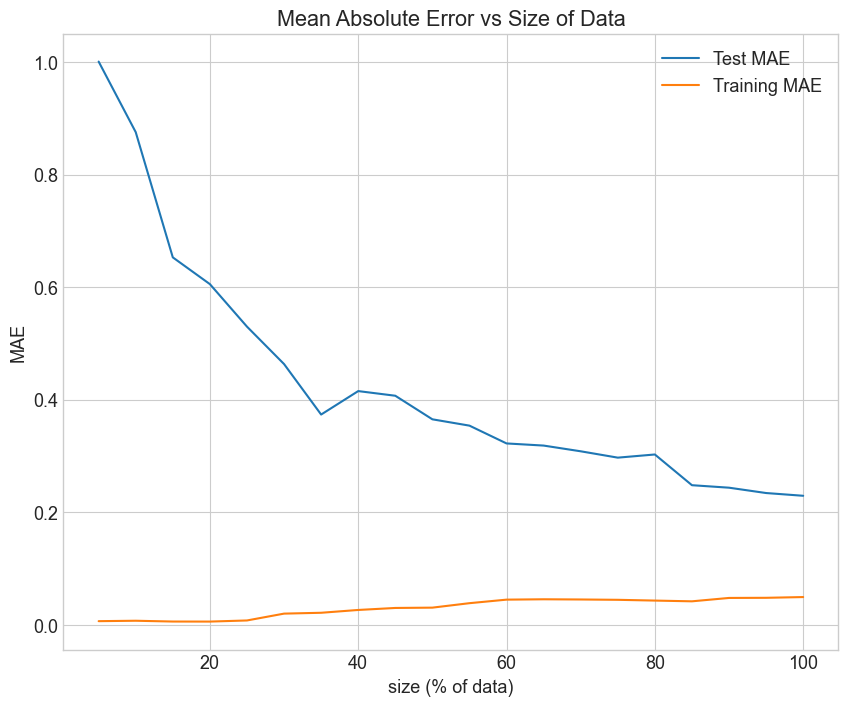

In [116]:
train_mae_by_size = results_xgb[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results_xgb[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results_xgb[:, [2]]

rcParams['figure.figsize']=10,8
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [117]:
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)


new_results = pd.DataFrame({"Test set": 'SiO2 == ARD == Quartz',
                            "Scenario 2 - Train Error %": [train_mae_pct],
                            "Scenario 2 - Test Error %": [test_mae_pct]})

results_compare_2 = pd.concat([results_compare_2, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.2293036637490778
Mean of Test results: 1.475907095691892
Percent Error on Test mean: 15.5%

Final MAE on Training results: 0.049273870580363234
Mean of Training results: 1.5105242016336489
Percent Error on Training mean: 3.3%


### XGB - Room Temperature Only

In [118]:
# Strip out the erosion rates and set them as y
y = data_base_names['Erosion Rate (mg/g)']
X = data_base_names.drop(columns='Erosion Rate (mg/g)')

# Do one-hot encoding for categorical variables (Only erodent type to begin)
X = pd.get_dummies(X)

X.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Eroded Material_Al,Eroded Material_Cu,Eroded Material_Fe,...,Erodent_Quartz,Erodent_SiC,Erodent_SiO2,Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel
count,922.000000,922.000000,910.000000,536.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,148.359490,135.985535,52.063736,6.310082,78.024946,0.175705,1992.761388,0.219089,0.009761,0.032538,...,0.134490,0.246204,0.225597,0.854664,0.036876,0.844902,0.062907,0.814534,0.127983,0.057484
std,102.085206,87.332032,28.686238,6.976491,140.701718,0.380776,22.008722,0.413854,0.098370,0.177520,...,0.341363,0.431033,0.418201,0.352631,0.188560,0.362194,0.242927,0.388886,0.334252,0.232891
min,7.730000,10.000000,3.000000,0.760000,-7.000000,0.000000,1960.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,74.000000,30.000000,3.750000,21.000000,0.000000,1970.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,127.000000,108.000000,45.000000,5.000000,21.000000,0.000000,1995.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,210.000000,152.000000,90.000000,7.400000,21.000000,0.000000,2014.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,490.000000,554.000000,90.000000,50.000000,800.000000,1.000000,2023.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [119]:
# Find a random state for splitting which gives a split with less than 5% difference in the y values
# Use 80% of data for training and 20% for test.
er_ratio = 0

i=-1
while not 0.95 <= er_ratio <= 1.05:
    i += 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
    er_ratio = y_train.mean()/y_test.mean()

print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")
print(f"Train/Test Erosion rate ratio: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")

Mean of Training results: 1.5105242016336489
Mean of Test results: 1.475907095691892
Train/Test Erosion rate ratio: 1.0234548001312567
random_state: 1


In [120]:
# Sanity check part 1
X_train_sanity = X_train.join(y_train)
X_test_sanity = X_test.join(y_test)
print('Before values for RT only:')
print(f"Mean of Training results: {X_train_sanity[X_train_sanity['Temperature (°C)'] < 31]['Erosion Rate (mg/g)'].mean()}")
print(f"Mean of Test results: {X_test_sanity[X_test_sanity['Temperature (°C)'] < 31]['Erosion Rate (mg/g)'].mean()}\n")

# Put training and test data/y back together to remove high temperature data
all_train = X_train.join(y_train)
all_test = X_test.join(y_test)

all_train = all_train[all_train['Temperature (°C)'] < 31]
all_test = all_test[all_test['Temperature (°C)'] < 31]

# Split everything back up
y_train = all_train['Erosion Rate (mg/g)']
X_train = all_train.drop(columns='Erosion Rate (mg/g)')

y_test = all_test['Erosion Rate (mg/g)']
X_test = all_test.drop(columns='Erosion Rate (mg/g)')

# Sanity check that splits are still the same
print('After values for RT only:')
print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")


Before values for RT only:
Mean of Training results: 1.7303295567181196
Mean of Test results: 1.6710991026339872

After values for RT only:
Mean of Training results: 1.7303295567181196
Mean of Test results: 1.6710991026339872


In [121]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
clf = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
clf.fit(X_train, y_train)

# print best parameter after tuning
print(clf.best_params_)

{'learning_rate': 0.13, 'n_estimators': 400}


In [122]:
# {'learning_rate': 0.13, 'n_estimators': 400} : Optimized

n_est = clf.best_params_['n_estimators']
lr = clf.best_params_['learning_rate']

In [123]:
results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=lr, n_estimators=n_est))
#results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.13, n_estimators=400))

Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

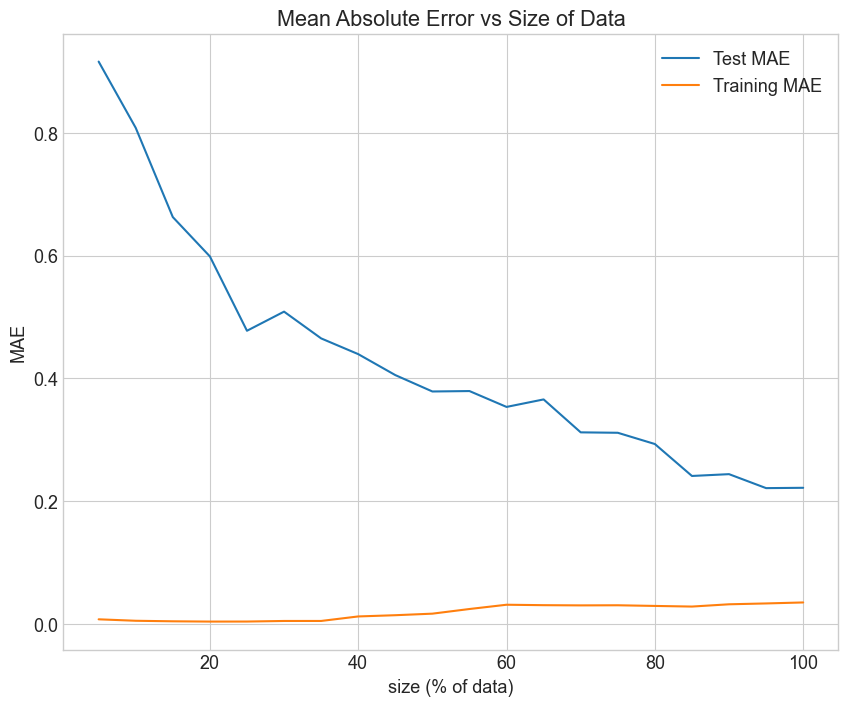

In [124]:
train_mae_by_size = results_xgb[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results_xgb[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results_xgb[:, [2]]

rcParams['figure.figsize']=10,8
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [125]:
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)


new_results = pd.DataFrame({"Test set": 'RT Only',
                            "Scenario 2 - Train Error %": [train_mae_pct],
                            "Scenario 2 - Test Error %": [test_mae_pct]})

results_compare_2 = pd.concat([results_compare_2, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.2218037294011217
Mean of Test results: 1.6710991026339872
Percent Error on Test mean: 13.3%

Final MAE on Training results: 0.035077519560635914
Mean of Training results: 1.7303295567181196
Percent Error on Training mean: 2.0%


### XGB - High Temperature Only

In [126]:
# Strip out the erosion rates and set them as y
y = data_base_names['Erosion Rate (mg/g)']
X = data_base_names.drop(columns='Erosion Rate (mg/g)')

# Do one-hot encoding for categorical variables (Only erodent type to begin)
X = pd.get_dummies(X)

X.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Eroded Material_Al,Eroded Material_Cu,Eroded Material_Fe,...,Erodent_Quartz,Erodent_SiC,Erodent_SiO2,Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel
count,922.000000,922.000000,910.000000,536.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,148.359490,135.985535,52.063736,6.310082,78.024946,0.175705,1992.761388,0.219089,0.009761,0.032538,...,0.134490,0.246204,0.225597,0.854664,0.036876,0.844902,0.062907,0.814534,0.127983,0.057484
std,102.085206,87.332032,28.686238,6.976491,140.701718,0.380776,22.008722,0.413854,0.098370,0.177520,...,0.341363,0.431033,0.418201,0.352631,0.188560,0.362194,0.242927,0.388886,0.334252,0.232891
min,7.730000,10.000000,3.000000,0.760000,-7.000000,0.000000,1960.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,74.000000,30.000000,3.750000,21.000000,0.000000,1970.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,127.000000,108.000000,45.000000,5.000000,21.000000,0.000000,1995.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,210.000000,152.000000,90.000000,7.400000,21.000000,0.000000,2014.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,490.000000,554.000000,90.000000,50.000000,800.000000,1.000000,2023.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [127]:
# Find a random state for splitting which gives a split with less than 5% difference in the y values
# Use 80% of data for training and 20% for test.
er_ratio = 0

i=-1
while not 0.95 <= er_ratio <= 1.05:
    i += 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
    er_ratio = y_train.mean()/y_test.mean()

print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")
print(f"Train/Test Erosion rate ratio: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")

Mean of Training results: 1.5105242016336489
Mean of Test results: 1.475907095691892
Train/Test Erosion rate ratio: 1.0234548001312567
random_state: 1


In [128]:
# Sanity check part 1
X_train_sanity = X_train.join(y_train)
X_test_sanity = X_test.join(y_test)
print('Before values for HT only:')
print(f"Mean of Training results: {X_train_sanity[X_train_sanity['Temperature (°C)'] > 31]['Erosion Rate (mg/g)'].mean()}")
print(f"Mean of Test results: {X_test_sanity[X_test_sanity['Temperature (°C)'] > 31]['Erosion Rate (mg/g)'].mean()}\n")

# Put training and test data/y back together to remove room temperature data
all_train = X_train.join(y_train)
all_test = X_test.join(y_test)

all_train = all_train[all_train['Temperature (°C)'] > 31]
all_test = all_test[all_test['Temperature (°C)'] > 31]

# Split everything back up
y_train = all_train['Erosion Rate (mg/g)']
X_train = all_train.drop(columns='Erosion Rate (mg/g)')

y_test = all_test['Erosion Rate (mg/g)']
X_test = all_test.drop(columns='Erosion Rate (mg/g)')

# Sanity check that splits are still the same
print('After values for HT only:')
print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")


Before values for HT only:
Mean of Training results: 0.5814178780141845
Mean of Test results: 0.5426453125

After values for HT only:
Mean of Training results: 0.5814178780141845
Mean of Test results: 0.5426453125


In [129]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
clf = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
clf.fit(X_train, y_train)

# print best parameter after tuning
print(clf.best_params_)

{'learning_rate': 0.23, 'n_estimators': 50}


In [130]:
# {'learning_rate': 0.23, 'n_estimators': 50} : Optimized

n_est = clf.best_params_['n_estimators']
lr = clf.best_params_['learning_rate']

In [131]:
results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=lr, n_estimators=n_est))
#results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.23, n_estimators=50))

Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

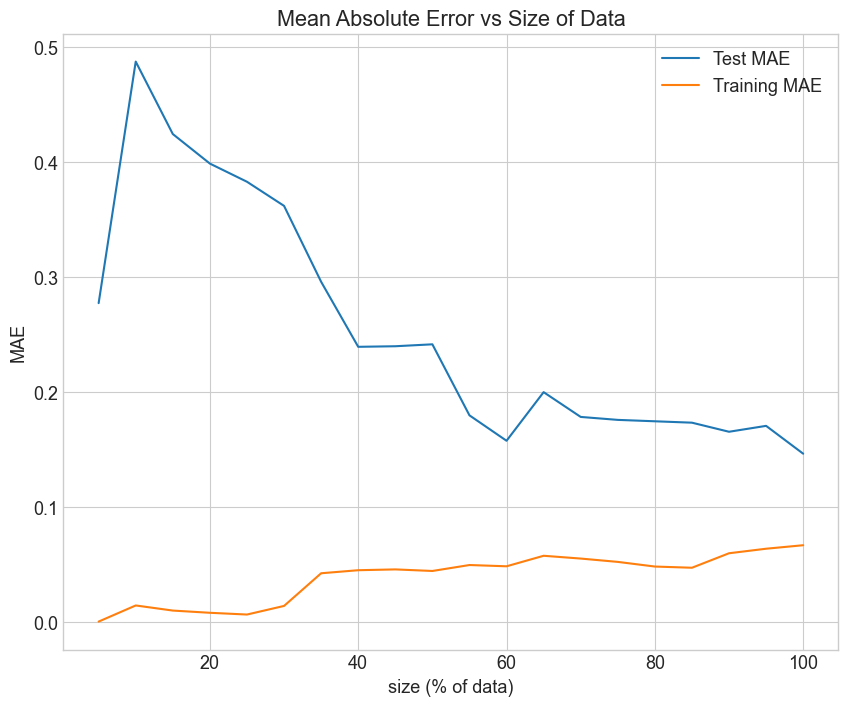

In [132]:

train_mae_by_size = results_xgb[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results_xgb[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results_xgb[:, [2]]

rcParams['figure.figsize']=10,8
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [133]:
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)


new_results = pd.DataFrame({"Test set": 'HT Only',
                            "Scenario 2 - Train Error %": [train_mae_pct],
                            "Scenario 2 - Test Error %": [test_mae_pct]})

results_compare_2 = pd.concat([results_compare_2, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.1464683083929587
Mean of Test results: 0.5426453125
Percent Error on Test mean: 27.0%

Final MAE on Training results: 0.06692990811825843
Mean of Training results: 0.5814178780141845
Percent Error on Training mean: 11.5%


In [134]:
results_compare_2

,Test set,Scenario 2 - Train Error %,Scenario 2 - Test Error %
0,Main model,3.7,15.5
1,SiO2 == ARD == Quartz,3.3,15.5
2,RT Only,2.0,13.3
3,HT Only,11.5,27.0


## Scenario 3 tests

In [135]:
# Create an array to hold the test results, add to others afterwards

results_compare_3 = pd.DataFrame(columns=['Test set', 'Scenario 3 - Train Error %', 'Scenario 3 - Test Error %'])

### Main model

In [136]:
# Strip out the erosion rates and set them as y
y = data_no_names['Erosion Rate (mg/g)']
X = data_no_names.drop(columns='Erosion Rate (mg/g)')

# Do one-hot encoding for categorical variables (erodent type, shape, carrier gas)
X = pd.get_dummies(X)

X.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Target Hardness (GPa),Target Hardness from Vickers,Target Hardness from Rockwell,...,Erodent Fracture toughness (MPa*m^0.5),Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel,Target Ductile/Brittle_B,Target Ductile/Brittle_D
count,922.000000,922.000000,910.000000,536.000000,922.000000,922.000000,922.000000,913.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,148.359490,135.985535,52.063736,6.310082,78.024946,0.175705,1992.761388,2.402378,0.925163,0.057484,...,2.432115,0.854664,0.036876,0.844902,0.062907,0.814534,0.127983,0.057484,0.017354,0.982646
std,102.085206,87.332032,28.686238,6.976491,140.701718,0.380776,22.008722,1.359130,0.263271,0.232891,...,1.797402,0.352631,0.188560,0.362194,0.242927,0.388886,0.334252,0.232891,0.130656,0.130656
min,7.730000,10.000000,3.000000,0.760000,-7.000000,0.000000,1960.000000,0.200000,0.000000,0.000000,...,0.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,74.000000,30.000000,3.750000,21.000000,0.000000,1970.000000,1.100000,1.000000,0.000000,...,0.730000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,127.000000,108.000000,45.000000,5.000000,21.000000,0.000000,1995.000000,2.980000,1.000000,0.000000,...,0.730000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,210.000000,152.000000,90.000000,7.400000,21.000000,0.000000,2014.000000,3.100000,1.000000,0.000000,...,4.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,490.000000,554.000000,90.000000,50.000000,800.000000,1.000000,2023.000000,8.000000,1.000000,1.000000,...,4.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [137]:
# Find a random state for splitting which gives a split with less than 5% difference in the y values
# Use 80% of data for training and 20% for test.
er_ratio = 0

i=-1
while not 0.95 <= er_ratio <= 1.05:
    i += 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
    er_ratio = y_train.mean()/y_test.mean()

print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")
print(f"Train/Test Erosion rate ratio: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")

Mean of Training results: 1.5105242016336489
Mean of Test results: 1.475907095691892
Train/Test Erosion rate ratio: 1.0234548001312567
random_state: 1


In [138]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
clf = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
clf.fit(X_train, y_train)

# print best parameter after tuning
print(clf.best_params_)

{'learning_rate': 0.06, 'n_estimators': 650}


In [139]:
# {'learning_rate': 0.06, 'n_estimators': 650} : Optimized

n_est = clf.best_params_['n_estimators']
lr = clf.best_params_['learning_rate']

In [140]:
results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=lr, n_estimators=n_est))
#results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.06, n_estimators=650))

Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

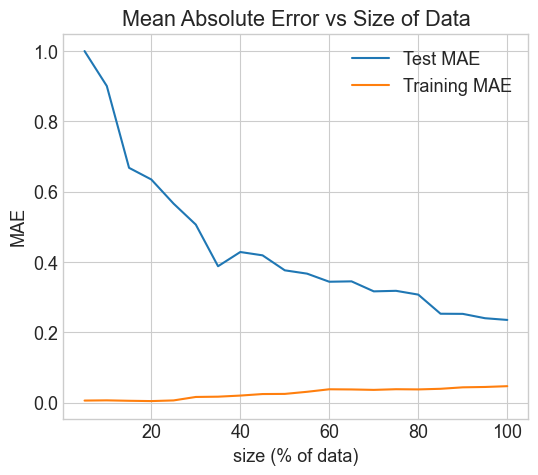

In [141]:
train_mae_by_size = results_xgb[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results_xgb[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results_xgb[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [142]:
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)


new_results = pd.DataFrame({"Test set": 'Main model',
                            "Scenario 3 - Train Error %": [train_mae_pct],
                            "Scenario 3 - Test Error %": [test_mae_pct]})

results_compare_3 = pd.concat([results_compare_3, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.23522642577507205
Mean of Test results: 1.475907095691892
Percent Error on Test mean: 15.9%

Final MAE on Training results: 0.04698308013300703
Mean of Training results: 1.5105242016336489
Percent Error on Training mean: 3.1%


#### Residuals

In [143]:
# Make a model with the optimized hyperparameters to calculated residuals on the test data
model = XGBRegressor(learning_rate=0.06, n_estimators=650)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test_np = y_test.to_numpy()

mae_spread = round(test_mae_pct/100,3)


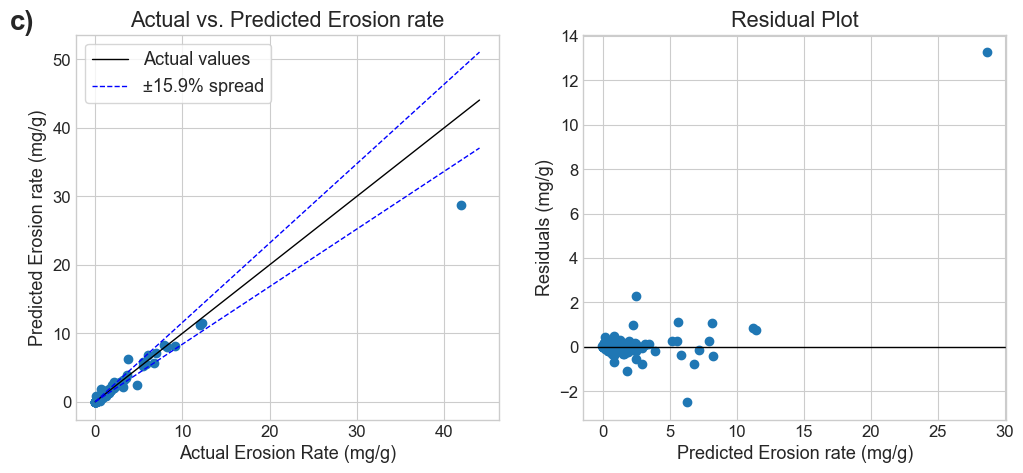

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

plt.rc('font', size=13)

# Plot actual vs predicted
axs[0].scatter(y_test_np, y_pred)
axs[0].set_xlabel('Actual Erosion Rate (mg/g)')
axs[0].set_ylabel('Predicted Erosion rate (mg/g)')
axs[0].set_title('Actual vs. Predicted Erosion rate')

# Get the current axes limits for plotting y = x line
xlims = axs[0].get_xlim()
ylims = axs[0].get_ylim()
min_val = min(xlims[0], ylims[0])
max_val = max(xlims[1], ylims[1])

# Plot the y=x line
axs[0].plot([0, max_val], [0, max_val], 'k', linewidth=1, label="Actual values")
# Plot the spread lines
axs[0].plot([0, max_val], [(1+mae_spread)*0, (1+mae_spread)*max_val], 'b--', linewidth=1, label=f"±{100*mae_spread}% spread")
axs[0].plot([0, max_val], [(1-mae_spread)*0, (1-mae_spread)*max_val], 'b--', linewidth=1)
axs[0].legend(frameon=True)

# Plot residuals
residuals = y_test_np - y_pred
axs[1].scatter(y_pred, residuals)
axs[1].set_xlabel('Predicted Erosion rate (mg/g)')
axs[1].set_ylabel('Residuals (mg/g)')
axs[1].set_title('Residual Plot')
plt.axhline(y=0, color='k', linewidth=1)

fig.text(0.07, 0.93, 'c)', fontsize=20, fontweight='bold', va='top')

# Change tick label size
axs[0].tick_params(axis='both', labelsize=12)
axs[1].tick_params(axis='both', labelsize=12)

plt.savefig("figure_3c.png", dpi=500, format="png")
plt.show()


In [145]:
test_value = test_mae_pct
percentage = percentage_within_error(y_test_np, y_pred, 0.01*test_value)
print(f"Percentage within {test_value}% error: {percentage:.2f}%")


Percentage within 15.9% error: 60.54%


#### 3.3 - VIF, Feature Importance and PDP

VIF, Feature Importance, and PDP from section 3.3 of the article are included here, as these results come directly from the model above.


In [146]:
# Multicollinearity tests. Start by removing categorical features and 
# use imputation to account for missing data.

y = data_no_names['Erosion Rate (mg/g)']
X = data_no_names.drop(columns='Erosion Rate (mg/g)')
X = pd.get_dummies(X)

X_mice = X.copy()

# Remove the categorical features
cat_feats = ['ASTM G76 Mentioned?', 'Shape_Angular', 'Shape_Spherical', 'Carrier Gas_Air',
             'Carrier Gas_Nitrogen', 'Test type_Gas Blast', 'Test type_Whirling Arm',
             'Test type_Windtunnel', 'Target Ductile/Brittle_B', 'Target Ductile/Brittle_D']

X_mice = X_mice.drop(columns=cat_feats)

# Perform imputation. Stary by creating a mask for missing values
missing_mask = X_mice.isna()

#Instantiate the MICE imputer
imputer = IterativeImputer(max_iter=20, random_state=0)

#Fit the imputer on the data and transform it to obtain the imputed values
imputed_values = imputer.fit_transform(X_mice)

# Convert imputed values back to a DataFrame with the same structure as X_mice
imputed_df = pd.DataFrame(imputed_values, index=X_mice.index, columns=X_mice.columns)

#Replace the missing values in the original dataset with the imputed values
X_mice[missing_mask] = imputed_df[missing_mask]

# Fit the StandardScaler on the numerical-only imputed dataset, and transform based on fit
scaler = StandardScaler()
scaler.fit(X_mice)

X_mice_scaled = scaler.transform(X_mice)

# Convert the scaled data back to a DataFrame, maintaining original column names
X_mice = pd.DataFrame(X_mice_scaled, columns=X_mice.columns)

print(get_vif(X_mice))

                                   Feature          VIF
0                       Particle Size (µm)     2.223579
1                           Velocity (m/s)     2.050836
2                           Incident angle     1.265851
3                     Nozzle Diameter (mm)     1.664185
4                         Temperature (°C)     1.336836
5                         Publication Year     2.515127
6                    Target Hardness (GPa)     9.248139
7             Target Hardness from Vickers    23.799657
8            Target Hardness from Rockwell    16.794651
9                  Target Density (kg/m^3)     3.739189
10            Target Elastic Modulus (GPa)    14.460382
11                    Target Poisson Ratio     8.143830
12     Target Thermal conductivity (W/m*K)    10.064022
13             Target Yield Strength (MPa)    94.532512
14           Target Tensile Strength (MPa)   124.150429
15   Target Fracture toughness (MPa*m^0.5)    10.454067
16                Target Melting Temp (°C)     6

In [147]:
# Create the model for feature importance, using optimized hyperparameters
fi_model = XGBRegressor(n_estimators=650, learning_rate=0.06)
fi_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=650, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

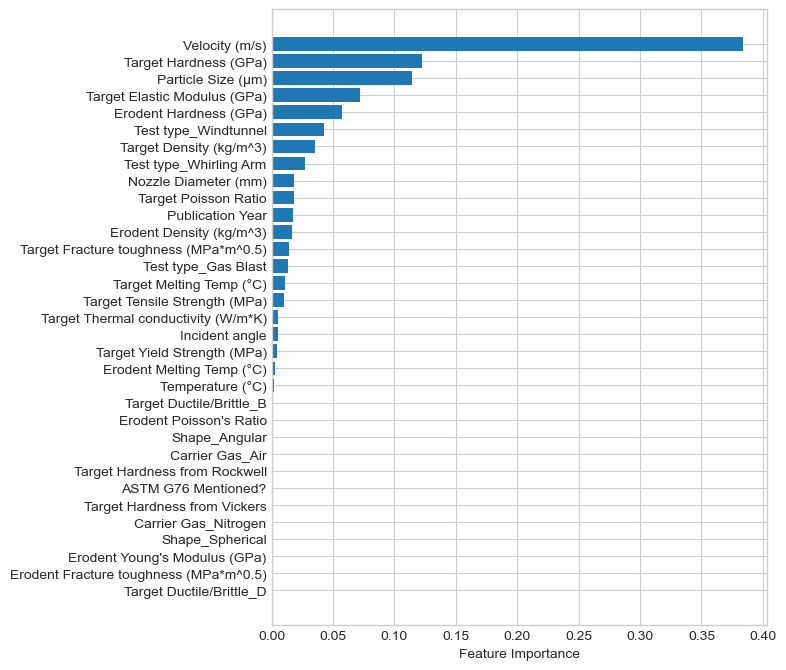

In [148]:
# Calculate and plot feature importance
sort = fi_model.feature_importances_.argsort()
feature_names = X.columns.to_numpy()  # Converts the column index to a numpy array

plt.figure(figsize=(9, 8))
plt.rc('font', size=10)

plt.barh(feature_names[sort], fi_model.feature_importances_[sort], height=0.8)
plt.xlabel("Feature Importance")

# Adjust spacing between labels
plt.subplots_adjust(left=0.35)

# Save then show the plot
plt.savefig('figure_5.pdf', format='pdf')
plt.show()

In [149]:
# Make a copy of the fit model for the PDP graphs
xgbr = fi_model.fit(X, y)

C:\Development\anaconda3\envs\ML\lib\site-packages\sklearn\inspection\_partial_dependence.py:508: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


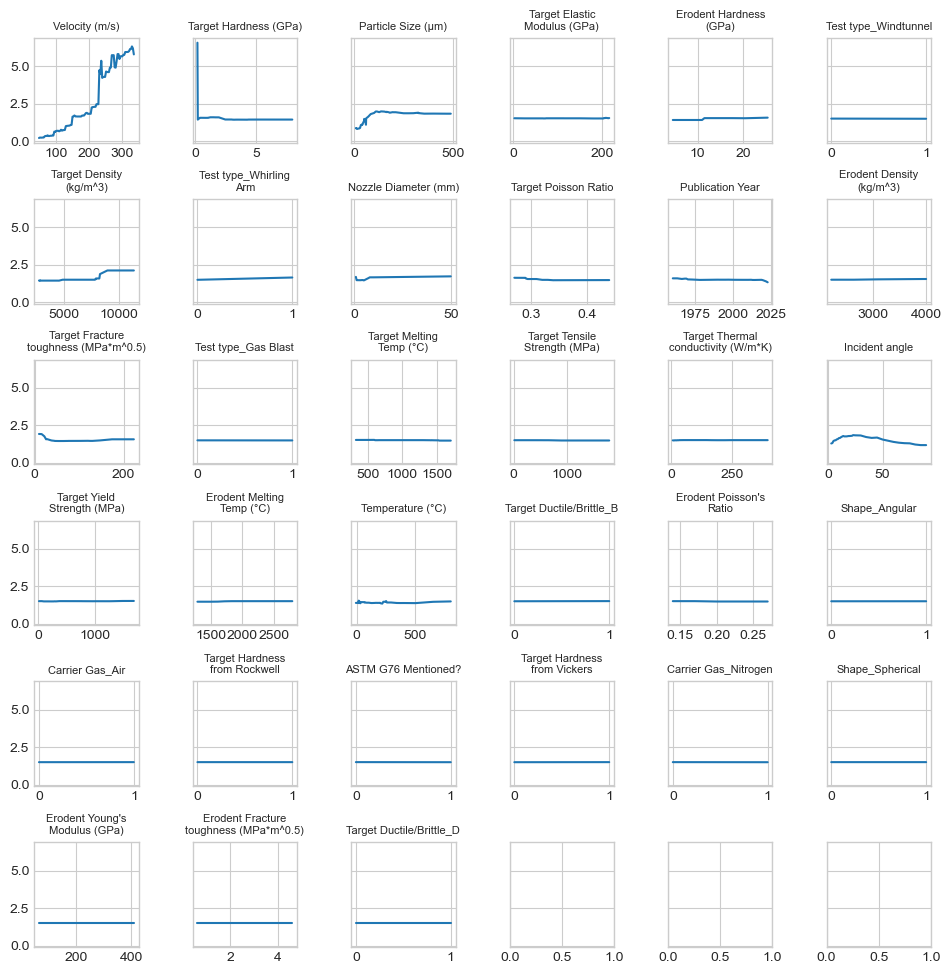

In [150]:
# Get all feature names from the dataframe
features = X.columns

# Extract feature importances from the model and sort features by importance in descending order
importances = xgbr.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in sorted_indices]

# Calculate partial dependence for each feature, sorted by importance
pdp_results = {}
for feature in sorted_features:
  pdp_results[feature] = partial_dependence(xgbr, X, features=[feature])

# Plot the partial dependence plots
feature_num = len(sorted_features)
graph_size = int(np.floor(np.sqrt(feature_num)) + 1)

plt.rcParams['figure.figsize'] = (10, 10)
fig, axs = plt.subplots(graph_size, graph_size, sharey=True)
fig.tight_layout(pad=2.5)

i, j, k = 0, 0, 0
while k < feature_num:
  if i == 0 and j == 0:
    axs[i, j].plot(pdp_results[sorted_features[k]][1][0], pdp_results[sorted_features[k]][0].T)
    axs[i, j].set_title(sorted_features[k], fontsize=8)
    j += 1
    k += 1
  while j < 6 and k < feature_num:
    axs[i, j].plot(pdp_results[sorted_features[k]][1][0], pdp_results[sorted_features[k]][0].T)
    if len(sorted_features[k]) > 21 and "Ductile" not in sorted_features[k]:
      index_second_space = sorted_features[k].find(' ', sorted_features[k].find(' ') + 1)
      title_with_linebreak = sorted_features[k][:index_second_space] + '\n' + sorted_features[k][index_second_space + 1:]
      axs[i, j].set_title(title_with_linebreak, fontsize=8)
    else:
      axs[i, j].set_title(sorted_features[k], fontsize=8)
    j += 1
    k += 1
  i += 1
  j = 0

plt.savefig('figure_6.pdf', format='pdf')
plt.show()


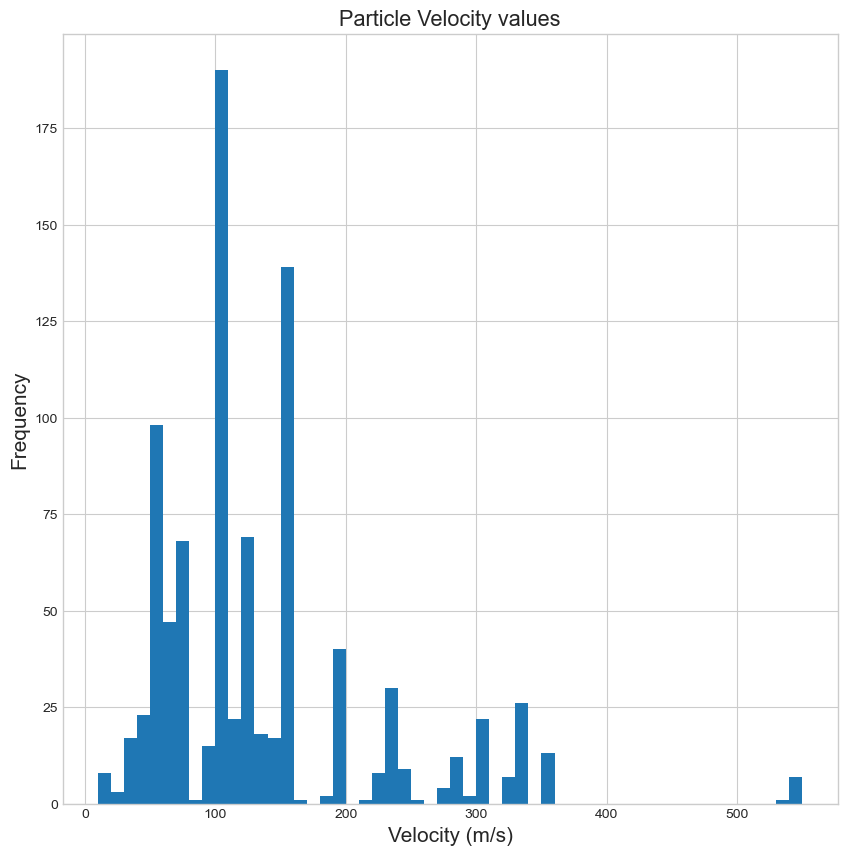

In [151]:
# Plot a histogram of velocity values, binned by 10 m/s

X.hist(column="Velocity (m/s)", bins=[10*i for i in range(1,56)])
plt.rc('font', size=13)
plt.xlabel("Velocity (m/s)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Particle Velocity values")

plt.savefig('figure_7.pdf', format='pdf')
plt.show()

### XGB - SiO2 == ARD == Quartz

This test is not applicable to scenario 3 as it does not use the erodent names.

In [152]:
new_results = pd.DataFrame({"Test set": 'SiO2 == ARD == Quartz',
                            "Scenario 3 - Train Error %": ["N/A"],
                            "Scenario 3 - Test Error %": ["N/A"]})

results_compare_3 = pd.concat([results_compare_3, new_results], ignore_index=True)

### XGB - Room Temperature Only

In [153]:
# Strip out the erosion rates and set them as y
y = data_no_names['Erosion Rate (mg/g)']
X = data_no_names.drop(columns='Erosion Rate (mg/g)')

# Do one-hot encoding for categorical variables (Only erodent type to begin)
X = pd.get_dummies(X)

X.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Target Hardness (GPa),Target Hardness from Vickers,Target Hardness from Rockwell,...,Erodent Fracture toughness (MPa*m^0.5),Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel,Target Ductile/Brittle_B,Target Ductile/Brittle_D
count,922.000000,922.000000,910.000000,536.000000,922.000000,922.000000,922.000000,913.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,148.359490,135.985535,52.063736,6.310082,78.024946,0.175705,1992.761388,2.402378,0.925163,0.057484,...,2.432115,0.854664,0.036876,0.844902,0.062907,0.814534,0.127983,0.057484,0.017354,0.982646
std,102.085206,87.332032,28.686238,6.976491,140.701718,0.380776,22.008722,1.359130,0.263271,0.232891,...,1.797402,0.352631,0.188560,0.362194,0.242927,0.388886,0.334252,0.232891,0.130656,0.130656
min,7.730000,10.000000,3.000000,0.760000,-7.000000,0.000000,1960.000000,0.200000,0.000000,0.000000,...,0.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,74.000000,30.000000,3.750000,21.000000,0.000000,1970.000000,1.100000,1.000000,0.000000,...,0.730000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,127.000000,108.000000,45.000000,5.000000,21.000000,0.000000,1995.000000,2.980000,1.000000,0.000000,...,0.730000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,210.000000,152.000000,90.000000,7.400000,21.000000,0.000000,2014.000000,3.100000,1.000000,0.000000,...,4.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,490.000000,554.000000,90.000000,50.000000,800.000000,1.000000,2023.000000,8.000000,1.000000,1.000000,...,4.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [154]:
# Find a random state for splitting which gives a split with less than 5% difference in the y values
# Use 80% of data for training and 20% for test.
er_ratio = 0

i=-1
while not 0.95 <= er_ratio <= 1.05:
    i += 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
    er_ratio = y_train.mean()/y_test.mean()

print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")
print(f"Train/Test Erosion rate ratio: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")

Mean of Training results: 1.5105242016336489
Mean of Test results: 1.475907095691892
Train/Test Erosion rate ratio: 1.0234548001312567
random_state: 1


In [155]:
# Sanity check part 1
X_train_sanity = X_train.join(y_train)
X_test_sanity = X_test.join(y_test)
print('Before values for RT only:')
print(f"Mean of Training results: {X_train_sanity[X_train_sanity['Temperature (°C)'] < 31]['Erosion Rate (mg/g)'].mean()}")
print(f"Mean of Test results: {X_test_sanity[X_test_sanity['Temperature (°C)'] < 31]['Erosion Rate (mg/g)'].mean()}\n")

# Put training and test data/y back together to remove high temperature data
all_train = X_train.join(y_train)
all_test = X_test.join(y_test)

all_train = all_train[all_train['Temperature (°C)'] < 31]
all_test = all_test[all_test['Temperature (°C)'] < 31]

# Split everything back up
y_train = all_train['Erosion Rate (mg/g)']
X_train = all_train.drop(columns='Erosion Rate (mg/g)')

y_test = all_test['Erosion Rate (mg/g)']
X_test = all_test.drop(columns='Erosion Rate (mg/g)')

# Sanity check that splits are still the same
print('After values for RT only:')
print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")


Before values for RT only:
Mean of Training results: 1.7303295567181196
Mean of Test results: 1.6710991026339872

After values for RT only:
Mean of Training results: 1.7303295567181196
Mean of Test results: 1.6710991026339872


In [156]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
clf = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
clf.fit(X_train, y_train)

# print best parameter after tuning
print(clf.best_params_)

{'learning_rate': 0.075, 'n_estimators': 400}


In [157]:
# {'learning_rate': 0.075, 'n_estimators': 400} : Optimized

n_est = clf.best_params_['n_estimators']
lr = clf.best_params_['learning_rate']

In [158]:
results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=lr, n_estimators=n_est))
#results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.075, n_estimators=400))

Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

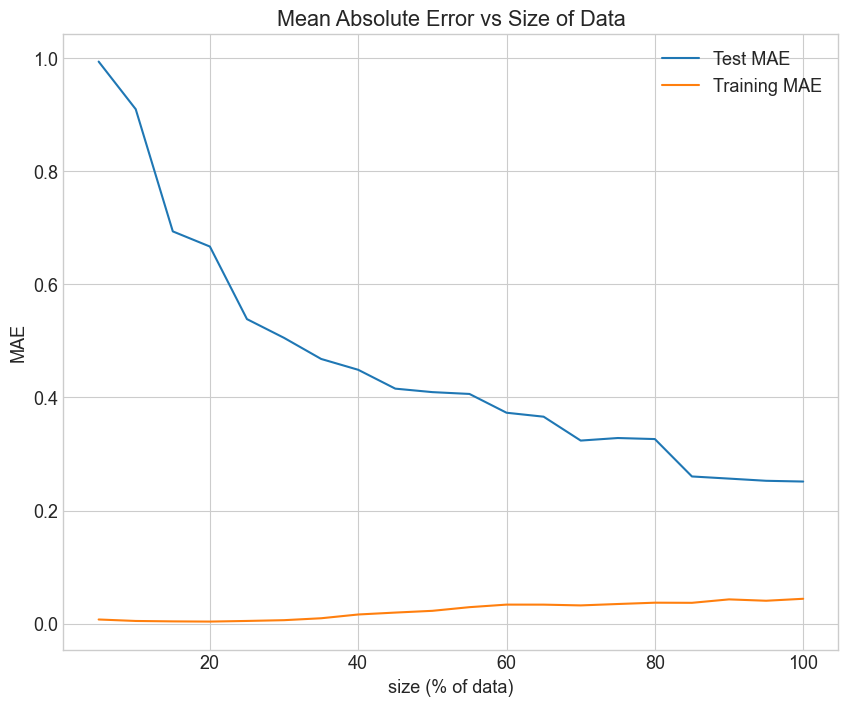

In [159]:
train_mae_by_size = results_xgb[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results_xgb[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results_xgb[:, [2]]

rcParams['figure.figsize']=10,8
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [160]:
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)


new_results = pd.DataFrame({"Test set": 'RT Only',
                            "Scenario 3 - Train Error %": [train_mae_pct],
                            "Scenario 3 - Test Error %": [test_mae_pct]})

results_compare_3 = pd.concat([results_compare_3, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.2512411667287758
Mean of Test results: 1.6710991026339872
Percent Error on Test mean: 15.0%

Final MAE on Training results: 0.04388007353351272
Mean of Training results: 1.7303295567181196
Percent Error on Training mean: 2.5%


### XGB - High Temperature Only

In [161]:
# Strip out the erosion rates and set them as y
y = data_no_names['Erosion Rate (mg/g)']
X = data_no_names.drop(columns='Erosion Rate (mg/g)')

# Do one-hot encoding for categorical variables (Only erodent type to begin)
X = pd.get_dummies(X)

X.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Target Hardness (GPa),Target Hardness from Vickers,Target Hardness from Rockwell,...,Erodent Fracture toughness (MPa*m^0.5),Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel,Target Ductile/Brittle_B,Target Ductile/Brittle_D
count,922.000000,922.000000,910.000000,536.000000,922.000000,922.000000,922.000000,913.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,148.359490,135.985535,52.063736,6.310082,78.024946,0.175705,1992.761388,2.402378,0.925163,0.057484,...,2.432115,0.854664,0.036876,0.844902,0.062907,0.814534,0.127983,0.057484,0.017354,0.982646
std,102.085206,87.332032,28.686238,6.976491,140.701718,0.380776,22.008722,1.359130,0.263271,0.232891,...,1.797402,0.352631,0.188560,0.362194,0.242927,0.388886,0.334252,0.232891,0.130656,0.130656
min,7.730000,10.000000,3.000000,0.760000,-7.000000,0.000000,1960.000000,0.200000,0.000000,0.000000,...,0.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,74.000000,30.000000,3.750000,21.000000,0.000000,1970.000000,1.100000,1.000000,0.000000,...,0.730000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,127.000000,108.000000,45.000000,5.000000,21.000000,0.000000,1995.000000,2.980000,1.000000,0.000000,...,0.730000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,210.000000,152.000000,90.000000,7.400000,21.000000,0.000000,2014.000000,3.100000,1.000000,0.000000,...,4.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,490.000000,554.000000,90.000000,50.000000,800.000000,1.000000,2023.000000,8.000000,1.000000,1.000000,...,4.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [162]:
# Find a random state for splitting which gives a split with less than 5% difference in the y values
# Use 80% of data for training and 20% for test.
er_ratio = 0

i=-1
while not 0.95 <= er_ratio <= 1.05:
    i += 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
    er_ratio = y_train.mean()/y_test.mean()

print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")
print(f"Train/Test Erosion rate ratio: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")

Mean of Training results: 1.5105242016336489
Mean of Test results: 1.475907095691892
Train/Test Erosion rate ratio: 1.0234548001312567
random_state: 1


In [163]:
# Sanity check part 1
X_train_sanity = X_train.join(y_train)
X_test_sanity = X_test.join(y_test)
print('Before values for HT only:')
print(f"Mean of Training results: {X_train_sanity[X_train_sanity['Temperature (°C)'] > 31]['Erosion Rate (mg/g)'].mean()}")
print(f"Mean of Test results: {X_test_sanity[X_test_sanity['Temperature (°C)'] > 31]['Erosion Rate (mg/g)'].mean()}\n")

# Put training and test data/y back together to remove room temperature data
all_train = X_train.join(y_train)
all_test = X_test.join(y_test)

all_train = all_train[all_train['Temperature (°C)'] > 31]
all_test = all_test[all_test['Temperature (°C)'] > 31]

# Split everything back up
y_train = all_train['Erosion Rate (mg/g)']
X_train = all_train.drop(columns='Erosion Rate (mg/g)')

y_test = all_test['Erosion Rate (mg/g)']
X_test = all_test.drop(columns='Erosion Rate (mg/g)')

# Sanity check that splits are still the same
print('After values for HT only:')
print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Test results: {y_test.mean()}")


Before values for HT only:
Mean of Training results: 0.5814178780141845
Mean of Test results: 0.5426453125

After values for HT only:
Mean of Training results: 0.5814178780141845
Mean of Test results: 0.5426453125


In [164]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
clf = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
clf.fit(X_train, y_train)

# print best parameter after tuning
print(clf.best_params_)

{'learning_rate': 0.09, 'n_estimators': 50}


In [165]:
# {'learning_rate': 0.09, 'n_estimators': 50} : Optimized

n_est = clf.best_params_['n_estimators']
lr = clf.best_params_['learning_rate']

In [166]:
results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=lr, n_estimators=n_est))
#results_xgb = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.09, n_estimators=50))

Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

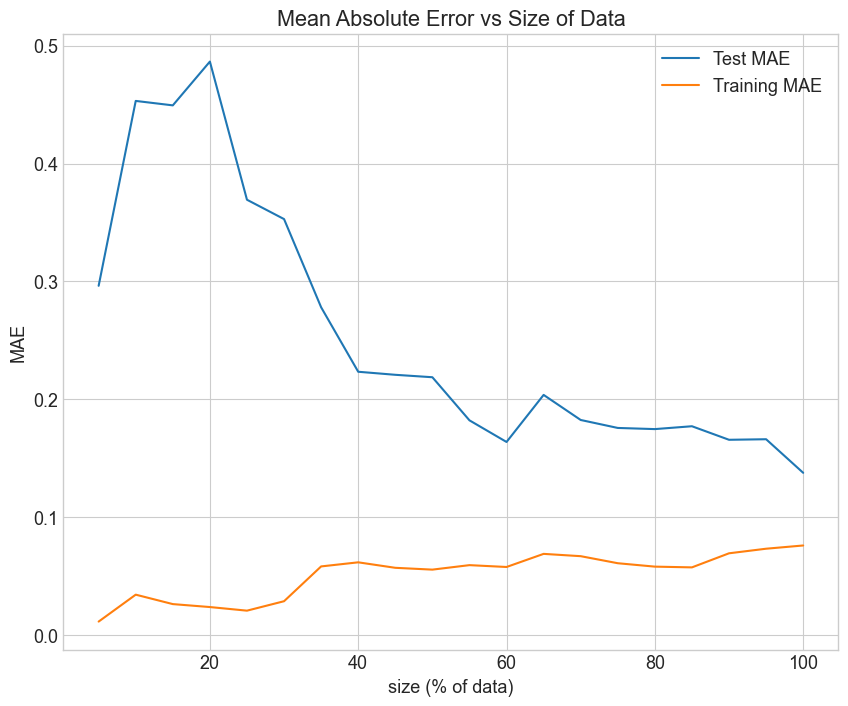

In [167]:
train_mae_by_size = results_xgb[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results_xgb[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results_xgb[:, [2]]

rcParams['figure.figsize']=10,8
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [168]:
train_mae_raw = train_mae_by_size[-1].item()
train_y_mean = y_train.mean()
train_mae_pct = round(100*train_mae_raw/train_y_mean,1)

test_mae_raw = test_mae_by_size[-1].item()
test_y_mean = y_test.mean()
test_mae_pct = round(100*test_mae_raw/test_y_mean,1)


new_results = pd.DataFrame({"Test set": 'HT Only',
                            "Scenario 3 - Train Error %": [train_mae_pct],
                            "Scenario 3 - Test Error %": [test_mae_pct]})

results_compare_3 = pd.concat([results_compare_3, new_results], ignore_index=True)

print(f"Final MAE on Test results: {test_mae_raw}")
print(f"Mean of Test results: {test_y_mean}")
print(f"Percent Error on Test mean: {test_mae_pct}%\n")

print(f"Final MAE on Training results: {train_mae_raw}")
print(f"Mean of Training results: {train_y_mean}")
print(f"Percent Error on Training mean: {train_mae_pct}%")

Final MAE on Test results: 0.13773136899941602
Mean of Test results: 0.5426453125
Percent Error on Test mean: 25.4%

Final MAE on Training results: 0.07610365790270204
Mean of Training results: 0.5814178780141845
Percent Error on Training mean: 13.1%


In [169]:
results_compare_3

,Test set,Scenario 3 - Train Error %,Scenario 3 - Test Error %
0,Main model,3.1,15.9
1,SiO2 == ARD == Quartz,N/A,N/A
2,RT Only,2.5,15.0
3,HT Only,13.1,25.4


## All results

In [170]:
merged_results = pd.merge(results_compare, results_compare_2, on='Test set', how='inner')
merged_results = pd.merge(merged_results, results_compare_3, on='Test set', how='inner')

merged_results

,Test set,Scenario 1 - Train Error %,Scenario 1 - Test Error %,Scenario 2 - Train Error %,Scenario 2 - Test Error %,Scenario 3 - Train Error %,Scenario 3 - Test Error %
0,Main model,3.4,15.4,3.7,15.5,3.1,15.9
1,SiO2 == ARD == Quartz,3.3,15.5,3.3,15.5,N/A,N/A
2,RT Only,3.4,14.1,2.0,13.3,2.5,15.0
3,HT Only,11.3,28.7,11.5,27.0,13.1,25.4


# 3.2.3 - Predicting ASTM G76

Note that this section provides predictions in mg/g. In the article, these are converted to mm^3/g using density values of 7.87 g/cm^3 for 1020 steel, and 8.00 g/cm^3 for stainless steel 304.

In [18]:
# Take in data for ASTM Tests. Will have to manually clean this to match formatting in each of the 3 chosen scenarios.

# Import data into pd DataFrames.
#cwd = f'{os.getcwd()}/' # on mac
cwd = f'{os.getcwd()}\\' # on windows

data_ASTM = pd.read_csv(f'{cwd}ASTM_G76_Tests_with_names.csv', delimiter=',')

data_ASTM.head()

,Eroded Material,Sample preparation,Material Treatment,Erodent,Shape,Size (µm),Size range (µm),Size (mesh),Velocity (m/s),V Pressure (PSI),...,Target Tensile Strength (MPa),Target Fracture toughness (MPa*m^0.5),Target Melting Temp (°C),Erodent Density (kg/m^3),Erodent Hardness (GPa),Erodent Melting Temp (°C),Erodent Young's Modulus (GPa),Erodent Poisson's Ratio,Erodent Fracture toughness (MPa*m^0.5),Erosion Rate (mg/g)
0,Steel - AISI 1020,As-received,NaN,Al2O3,Angular,50,NaN,NaN,30,NaN,...,420,37,1440,3960,20.5,2054,370,0.22,4,NaN
1,Steel - AISI 1020,As-received,NaN,Al2O3,Angular,50,NaN,NaN,70,NaN,...,420,37,1440,3960,20.5,2054,370,0.22,4,NaN
2,Steel - Stainless 304,As-received,NaN,Al2O3,Angular,50,NaN,NaN,70,NaN,...,580,174,1425,3960,20.5,2054,370,0.22,4,NaN


In [19]:
# Remove columns we don't use, and leftovers from combining data
data_ASTM_reduced = data_ASTM.drop(columns=['Sample preparation', 'Material Treatment', 'Erosion Rate (mm^3/g)', 
                                            'Quality score', 'Source','Note', 'Column1','Column2','Unnamed: 34'])

# Change ASTM values to 0 and 1 rather than yes/no
data_ASTM_reduced = data_ASTM_reduced.replace({'ASTM G76 Mentioned?':{'Yes':1, 'No': 0}})

# Rename particle size column for clarity
data_ASTM_reduced = data_ASTM_reduced.rename(columns={"Size (µm)":"Particle Size (µm)"})


In [20]:
# Use the same "cols_with_missing" previously defined for the full database.
smallest_ASTM_data = data_ASTM_reduced.drop(cols_with_missing, axis=1)

smallest_ASTM_data.head()


,Eroded Material,Erodent,Shape,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Nozzle Ratio,Carrier Gas,Temperature (°C),...,Target Tensile Strength (MPa),Target Fracture toughness (MPa*m^0.5),Target Melting Temp (°C),Erodent Density (kg/m^3),Erodent Hardness (GPa),Erodent Melting Temp (°C),Erodent Young's Modulus (GPa),Erodent Poisson's Ratio,Erodent Fracture toughness (MPa*m^0.5),Erosion Rate (mg/g)
0,Steel - AISI 1020,Al2O3,Angular,50,30,90,1.5,33.33,Air,21,...,420,37,1440,3960,20.5,2054,370,0.22,4,NaN
1,Steel - AISI 1020,Al2O3,Angular,50,70,90,1.5,33.33,Air,21,...,420,37,1440,3960,20.5,2054,370,0.22,4,NaN
2,Steel - Stainless 304,Al2O3,Angular,50,70,90,1.5,33.33,Air,21,...,580,174,1425,3960,20.5,2054,370,0.22,4,NaN


In [21]:
# Scenario 1 - List the material properties to be removed
material_properties = ['Target Hardness (GPa)', 'Target Hardness from Vickers', 'Target Hardness from Rockwell', 
                       'Target Density (kg/m^3)', 'Target Elastic Modulus (GPa)', 'Target Poisson Ratio', 
                       'Target Thermal conductivity (W/m*K)', 'Target Yield Strength (MPa)', 'Target Tensile Strength (MPa)', 
                       'Target Fracture toughness (MPa*m^0.5)', 'Target Melting Temp (°C)', 'Target Ductile/Brittle', 
                       'Erodent Density (kg/m^3)', 'Erodent Hardness (GPa)', 'Erodent Melting Temp (°C)', 
                       'Erodent Young\'s Modulus (GPa)', 'Erodent Poisson\'s Ratio', 'Erodent Fracture toughness (MPa*m^0.5)']

# Remove material properties to get names only
ASTM_data_names_only = smallest_ASTM_data.drop(columns=material_properties)

# Change Ti-6Al-4V to all use the same labels
def replace_Ti64(material):
  return re.sub(r'Ti-6Al-4V.*', 'Ti-6Al-4V', material)

ASTM_data_names_only['Eroded Material'] = ASTM_data_names_only['Eroded Material'].apply(replace_Ti64) # No Ti alloys here, so not doing anything

ASTM_data_names_only['Eroded Material'].unique()

array(['Steel - AISI 1020', 'Steel - Stainless 304'], dtype=object)

In [22]:
# Scenario 2 - Create the base-names dataset
ASTM_data_base_names = ASTM_data_names_only.copy()

# Define a dictionary map for base material neames
base_names = {
  # 'Ti-6Al-4V.*': 'Ti-6Al-4V', Ignore as we did this in the previous step
  'Ti.*': 'Ti',
  'VT.*': 'Ti',
  'Steel.*': 'Steel',
  'Ni.*': 'Ni',
  'Al.*': 'Al'
}

def replace_material_name(material):
  for pattern, replacement in base_names.items():
    if re.match(pattern, material):
      return replacement
  else:
    return material  # Only return the original material if no match was found

ASTM_data_base_names['Eroded Material'] = ASTM_data_base_names['Eroded Material'].apply(replace_material_name)

ASTM_data_base_names['Eroded Material'].unique()

array(['Steel'], dtype=object)

In [23]:
# Scenario 3 - Remove only the material names
ASTM_data_no_names = smallest_ASTM_data.drop(columns=['Eroded Material','Erodent'])

In [24]:
# Create an array to hold the test results and convert to dataframe
ASTM_tests = {'Test': ['Steel - SAE 1020 - 30 m/s', 'Steel - SAE 1020 - 70 m/s','Steel - Stainless 304 - 70 m/s']}

ASTM_results_compare = pd.DataFrame(ASTM_tests)

## Scenario 1 predictions

In [25]:
# Strip out the erosion rates and set them as y
y = data_names_only['Erosion Rate (mg/g)']
X = data_names_only.drop(columns='Erosion Rate (mg/g)')

# Do one-hot encoding for categorical variables (erodent type, shape, carrier gas)
X = pd.get_dummies(X)

In [26]:
# Our test data does not include the full range of categorical values,
# so need to add the extra columns for one-hot encoding manually.

# get dummies for test data, and add any missing (empty) columns
ASTM_data_names_only = pd.get_dummies(ASTM_data_names_only)

# Find missing columns
missing_cols = [col for col in X.columns if col not in ASTM_data_names_only.columns]

# Add missing columns to smallest_data_test with zeros
ASTM_data_names_only = ASTM_data_names_only.assign(**{col: 0 for col in missing_cols})

# Finally, sort out the order of all columns
# Get desired column order from df1
column_order = X.columns.tolist()

# Reorder columns of df2 to match df1
ASTM_data_names_only = ASTM_data_names_only[column_order]

ASTM_data_names_only.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Eroded Material_Al,Eroded Material_Al - 1100-O,Eroded Material_Al - 2024,...,Erodent_Quartz,Erodent_SiC,Erodent_SiO2,Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel
count,3.0,3.000000,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
mean,50.0,56.666667,90.0,1.5,21.0,1.0,2013.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
std,0.0,23.094011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,50.0,30.000000,90.0,1.5,21.0,1.0,2013.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
25%,50.0,50.000000,90.0,1.5,21.0,1.0,2013.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
50%,50.0,70.000000,90.0,1.5,21.0,1.0,2013.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
75%,50.0,70.000000,90.0,1.5,21.0,1.0,2013.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
max,50.0,70.000000,90.0,1.5,21.0,1.0,2013.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [27]:
# {'learning_rate': 0.13, 'n_estimators': 300} ### from previous optimization

model = XGBRegressor(n_estimators=300, learning_rate=0.13)
model.fit(X, y)
predictions = model.predict(ASTM_data_names_only)

preds = pd.DataFrame(predictions, columns=['Scenario 1 - ASTM Predictions (mg/g)'])



In [28]:
ASTM_results_compare['Scenario 1 - ASTM Predictions (mg/g)'] = preds

ASTM_results_compare

,Test,Scenario 1 - ASTM Predictions (mg/g)
0,Steel - SAE 1020 - 30 m/s,0.019422
1,Steel - SAE 1020 - 70 m/s,0.153323
2,Steel - Stainless 304 - 70 m/s,0.371645


## Scenario 2 predictions

In [29]:
# Strip out the erosion rates and set them as y
y = data_base_names['Erosion Rate (mg/g)']
X = data_base_names.drop(columns='Erosion Rate (mg/g)')

# Do one-hot encoding for categorical variables (erodent type, shape, carrier gas)
X = pd.get_dummies(X)

In [30]:
# Our test data does not include the full range of categorical values,
# so need to add the extra columns for one-hot encoding manually.

# get dummies for test data, and add any missing (empty) columns
ASTM_data_base_names = pd.get_dummies(ASTM_data_base_names)

# Find missing columns
missing_cols = [col for col in X.columns if col not in ASTM_data_base_names.columns]

# Add missing columns to smallest_data_test with zeros
ASTM_data_base_names = ASTM_data_base_names.assign(**{col: 0 for col in missing_cols})

# Finally, sort out the order of columns
# Get desired column order from df1
column_order = X.columns.tolist()

# Reorder columns of df2 to match df1
ASTM_data_base_names = ASTM_data_base_names[column_order]

ASTM_data_base_names.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Eroded Material_Al,Eroded Material_Cu,Eroded Material_Fe,...,Erodent_Quartz,Erodent_SiC,Erodent_SiO2,Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel
count,3.0,3.000000,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
mean,50.0,56.666667,90.0,1.5,21.0,1.0,2013.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
std,0.0,23.094011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,50.0,30.000000,90.0,1.5,21.0,1.0,2013.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
25%,50.0,50.000000,90.0,1.5,21.0,1.0,2013.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
50%,50.0,70.000000,90.0,1.5,21.0,1.0,2013.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
75%,50.0,70.000000,90.0,1.5,21.0,1.0,2013.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
max,50.0,70.000000,90.0,1.5,21.0,1.0,2013.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [31]:
# {'learning_rate': 0.13, 'n_estimators': 250} ### from previous optimization

model = XGBRegressor(n_estimators=250, learning_rate=0.13)
model.fit(X, y)
predictions = model.predict(ASTM_data_base_names)

preds = pd.DataFrame(predictions, columns=['Scenario 2 - ASTM Predictions'])

# Add predictions to the dataframe and show
ASTM_results_compare['Scenario 2 - ASTM Predictions (mg/g)'] = preds

ASTM_results_compare

,Test,Scenario 1 - ASTM Predictions (mg/g),Scenario 2 - ASTM Predictions (mg/g)
0,Steel - SAE 1020 - 30 m/s,0.019422,0.186032
1,Steel - SAE 1020 - 70 m/s,0.153323,0.239551
2,Steel - Stainless 304 - 70 m/s,0.371645,0.239551


## Scenario 3 predictions

In [32]:
# Strip out the erosion rates and set them as y
y = data_no_names['Erosion Rate (mg/g)']
X = data_no_names.drop(columns='Erosion Rate (mg/g)')

# Do one-hot encoding for categorical variables (erodent type, shape, carrier gas)
X = pd.get_dummies(X)

In [33]:
# Our test data does not include the full range of categorical values,
# so need to add the extra columns for one-hot encoding manually.

# get dummies for test data, and add any missing (empty) columns
ASTM_data_no_names = pd.get_dummies(ASTM_data_no_names)

# Find missing columns
missing_cols = [col for col in X.columns if col not in ASTM_data_no_names.columns]
#print(missing_cols)

# Add missing columns to smallest_data_test with zeros
ASTM_data_no_names = ASTM_data_no_names.assign(**{col: 0 for col in missing_cols})

# Finally, sort out the order of columns
# Get desired column order from df1
column_order = X.columns.tolist()

# Reorder columns of df2 to match df1
ASTM_data_no_names = ASTM_data_no_names[column_order]

ASTM_data_no_names.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Target Hardness (GPa),Target Hardness from Vickers,Target Hardness from Rockwell,...,Erodent Fracture toughness (MPa*m^0.5),Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel,Target Ductile/Brittle_B,Target Ductile/Brittle_D
count,3.0,3.000000,3.0,3.0,3.0,3.0,3.0,3.000000,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
mean,50.0,56.666667,90.0,1.5,21.0,1.0,2013.0,1.128333,1.0,0.0,...,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
std,0.0,23.094011,0.0,0.0,0.0,0.0,0.0,0.118357,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,50.0,30.000000,90.0,1.5,21.0,1.0,2013.0,1.060000,1.0,0.0,...,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
25%,50.0,50.000000,90.0,1.5,21.0,1.0,2013.0,1.060000,1.0,0.0,...,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
50%,50.0,70.000000,90.0,1.5,21.0,1.0,2013.0,1.060000,1.0,0.0,...,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
75%,50.0,70.000000,90.0,1.5,21.0,1.0,2013.0,1.162500,1.0,0.0,...,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
max,50.0,70.000000,90.0,1.5,21.0,1.0,2013.0,1.265000,1.0,0.0,...,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [34]:
# {'learning_rate': 0.06, 'n_estimators': 650} ### from previous optimization

model = XGBRegressor(n_estimators=650, learning_rate=0.06)
model.fit(X, y)
predictions = model.predict(ASTM_data_no_names)

preds = pd.DataFrame(predictions, columns=['Scenario 3 - ASTM Predictions'])

# Add predictions to the dataframe and show
ASTM_results_compare['Scenario 3 - ASTM Predictions (mg/g)'] = preds

ASTM_results_compare


,Test,Scenario 1 - ASTM Predictions (mg/g),Scenario 2 - ASTM Predictions (mg/g),Scenario 3 - ASTM Predictions (mg/g)
0,Steel - SAE 1020 - 30 m/s,0.019422,0.186032,0.167740
1,Steel - SAE 1020 - 70 m/s,0.153323,0.239551,0.253111
2,Steel - Stainless 304 - 70 m/s,0.371645,0.239551,0.274978


# 3.4 - Other tests

# Numerical Encoding of Categorical Features

In [188]:
# Strip out the erosion rates and set them as y
y = data_no_names['Erosion Rate (mg/g)']
X = data_no_names.drop(columns='Erosion Rate (mg/g)')

cat_feats = X.select_dtypes(include='object').columns.values.tolist()

In [189]:
# From the categorical feature list, create a dictionary to relate values to integers

feat_dict = {}
for feature in cat_feats:
  cat_feat_list = X[feature].unique()
  # Remove NaN values so they don't get assigned a value 
  cat_feat_list = cat_feat_list[~pd.isnull(cat_feat_list)]
  
  i=int(0)
  for feature_val in cat_feat_list:
    feat_dict[feature_val] = i
    i+=1

In [190]:
# Print out the relationship between categorical features and integers
feat_dict

{'Angular': 0,
 'Spherical': 1,
 'Air': 0,
 'Nitrogen': 1,
 'Gas Blast': 0,
 'Windtunnel': 1,
 'Whirling Arm': 2,
 'D': 0,
 'B': 1}

In [191]:
# Create a copy and replace categorical feature values from previously-defined dictionary
X_num=X.copy()
X_num[cat_feats] = X_num[cat_feats].replace(to_replace=feat_dict)


In [192]:
X_num.describe()

,Shape,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Carrier Gas,Temperature (°C),ASTM G76 Mentioned?,Publication Year,Test type,...,Target Yield Strength (MPa),Target Tensile Strength (MPa),Target Fracture toughness (MPa*m^0.5),Target Melting Temp (°C),Erodent Density (kg/m^3),Erodent Hardness (GPa),Erodent Melting Temp (°C),Erodent Young's Modulus (GPa),Erodent Poisson's Ratio,Erodent Fracture toughness (MPa*m^0.5)
count,822.000000,922.000000,922.000000,910.000000,536.000000,837.000000,922.000000,922.000000,922.000000,922.000000,...,908.000000,916.000000,898.000000,913.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,0.041363,148.359490,135.985535,52.063736,6.310082,0.069295,78.024946,0.175705,1992.761388,0.313449,...,597.630727,717.451965,80.078508,1330.933187,3017.689805,16.992451,2059.636659,224.035792,0.176182,2.432115
std,0.199249,102.085206,87.332032,28.686238,6.976491,0.254107,140.701718,0.380776,22.008722,0.686786,...,408.764554,429.484603,38.010483,414.065860,597.522735,6.143201,452.070925,159.612981,0.030917,1.797402
min,0.000000,7.730000,10.000000,3.000000,0.760000,0.000000,-7.000000,0.000000,1960.000000,0.000000,...,9.000000,15.000000,10.000000,328.000000,2230.000000,4.500000,1283.000000,63.000000,0.140000,0.630000
25%,0.000000,55.000000,74.000000,30.000000,3.750000,0.000000,21.000000,0.000000,1970.000000,0.000000,...,130.000000,310.000000,44.000000,1298.000000,2450.000000,11.500000,1713.000000,70.000000,0.170000,0.730000
50%,0.000000,127.000000,108.000000,45.000000,5.000000,0.000000,21.000000,0.000000,1995.000000,0.000000,...,790.000000,900.000000,76.000000,1510.000000,2650.000000,11.500000,1830.000000,70.000000,0.170000,0.730000
75%,0.000000,210.000000,152.000000,90.000000,7.400000,0.000000,21.000000,0.000000,2014.000000,0.000000,...,830.000000,930.000000,103.000000,1650.000000,3100.000000,20.500000,2054.000000,370.000000,0.200000,4.000000
max,1.000000,490.000000,554.000000,90.000000,50.000000,1.000000,800.000000,1.000000,2023.000000,2.000000,...,1700.000000,1800.000000,223.000000,1704.000000,4000.000000,25.500000,2797.000000,410.000000,0.270000,4.600000


In [193]:
# Find a random state which gives a split with less than 5% difference in the y values
scaling_factor = 0

i=-1
while not 0.95 <= scaling_factor <= 1.05:
  i += 1
  X_train, X_test, y_train, y_test = train_test_split(X_num, y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
  scaling_factor = y_train.mean()/y_test.mean()
  
print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Validation results: {y_test.mean()}")
print(f"scaling factor: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")


Mean of Training results: 1.5105242016336489
Mean of Validation results: 1.475907095691892
scaling factor: 1.0234548001312567
random_state: 1


In [194]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
xgbr = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
xgbr.fit(X_train, y_train)

# print best parameter after tuning
print(xgbr.best_params_)

{'learning_rate': 0.225, 'n_estimators': 100}


In [195]:
# {'learning_rate': 0.225, 'n_estimators': 100} : Optimized

n_est = xgbr.best_params_['n_estimators']
lr = xgbr.best_params_['learning_rate']

In [196]:
results = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(n_estimators=n_est, learning_rate=lr))
#results = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.225, n_estimators=100))

Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

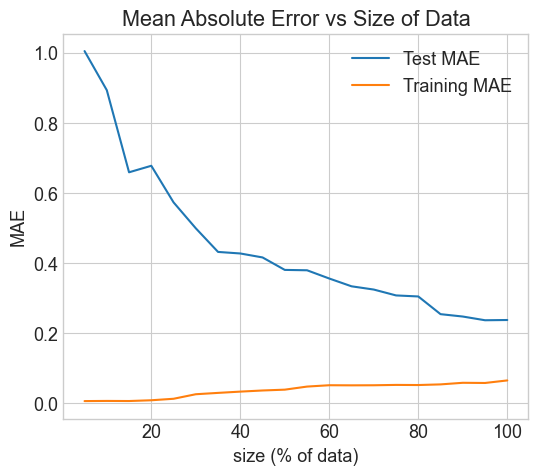

In [197]:

train_mae_by_size = results[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [198]:
print(f"Final MAE on Validation results: {test_mae_by_size[-1].item()}")
print(f"Mean of Validation results: {y_test.mean()}")
print(f"Percent Error on Validation mean: {round(100*test_mae_by_size[-1].item()/y_test.mean(),1)}%\n")

print(f"Final MAE on Training results: {train_mae_by_size[-1].item()}")
print(f"Mean of Training results: {y_train.mean()}")
print(f"Percent Error on Training mean: {round(100*train_mae_by_size[-1].item()/y_train.mean(),1)}%")

Final MAE on Validation results: 0.23746619101438854
Mean of Validation results: 1.475907095691892
Percent Error on Validation mean: 16.1%

Final MAE on Training results: 0.06509831197083839
Mean of Training results: 1.5105242016336489
Percent Error on Training mean: 4.3%


#### Feature Importance and PDP

Feature Importance

In [203]:
#fi_model = XGBRegressor(n_estimators=100, learning_rate=0.225)
fi_model = XGBRegressor(n_estimators=n_est, learning_rate=lr)
fi_model.fit(X_num, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.225, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Text(0.5, 0, 'Feature Importance')

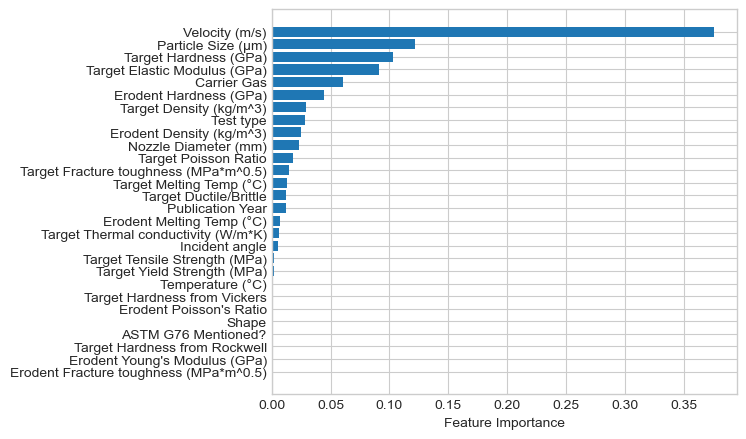

In [204]:
sort = fi_model.feature_importances_.argsort()

feature_names = X_train.columns.to_numpy()  # Converts the column index to a numpy array

plt.rc('font', size=10)
plt.barh(feature_names[sort], fi_model.feature_importances_[sort])
plt.xlabel("Feature Importance")


Partial Dependence Plots

In [205]:
xgbr = fi_model.fit(X_num, y)


C:\Development\anaconda3\envs\ML\lib\site-packages\sklearn\inspection\_partial_dependence.py:508: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


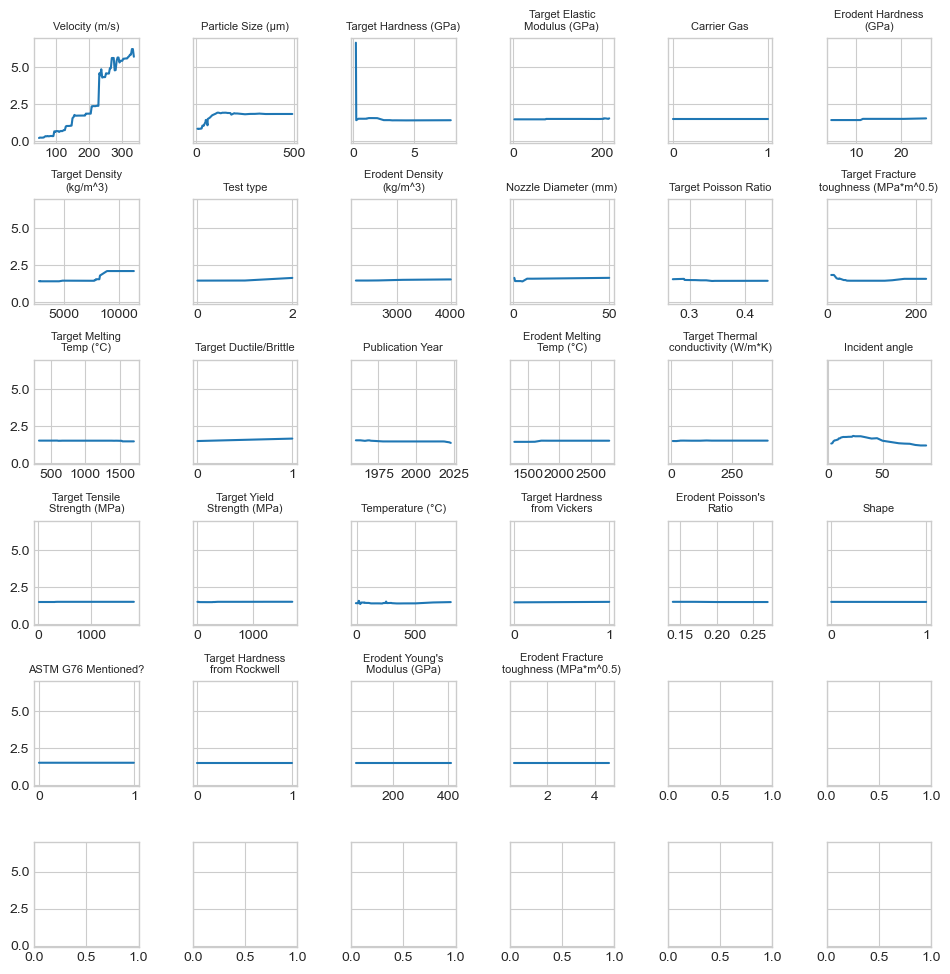

In [206]:
# Get all feature names from the dataframe
features = X_num.columns

# Extract feature importances from the model and sort features by importance in descending order
importances = xgbr.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in sorted_indices]

# Calculate partial dependence for each feature, sorted by importance
pdp_results = {}
for feature in sorted_features:
    pdp_results[feature] = partial_dependence(xgbr, X_num, features=[feature])

# Plot the partial dependence plots
feature_num = len(sorted_features)
graph_size = int(np.floor(np.sqrt(feature_num)) + 1)

plt.rcParams['figure.figsize'] = (10, 10)
fig, axs = plt.subplots(graph_size, graph_size, sharey=True)
fig.tight_layout(pad=2.5)

i, j, k = 0, 0, 0
while k < feature_num:
    if i == 0 and j == 0:
        axs[i, j].plot(pdp_results[sorted_features[k]][1][0], pdp_results[sorted_features[k]][0].T)
        axs[i, j].set_title(sorted_features[k], fontsize=8)
        j += 1
        k += 1
    while j < 6 and k < feature_num:
        axs[i, j].plot(pdp_results[sorted_features[k]][1][0], pdp_results[sorted_features[k]][0].T)
        if len(sorted_features[k]) > 21 and "Ductile" not in sorted_features[k]:
            index_second_space = sorted_features[k].find(' ', sorted_features[k].find(' ') + 1)
            title_with_linebreak = sorted_features[k][:index_second_space] + '\n' + sorted_features[k][index_second_space + 1:]
            axs[i, j].set_title(title_with_linebreak, fontsize=8)
        else:
            axs[i, j].set_title(sorted_features[k], fontsize=8)
        j += 1
        k += 1
    i += 1
    j = 0

plt.savefig('figure_6.pdf', format='pdf')
plt.show()


## Imputation tests

In [207]:
# Strip out the erosion rates and set them as y
y = data_no_names['Erosion Rate (mg/g)']
X = data_no_names.drop(columns='Erosion Rate (mg/g)')

# Do one-hot encoding for categorical variables (erodent type, shape, carrier gas)
X = pd.get_dummies(X)

X.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Target Hardness (GPa),Target Hardness from Vickers,Target Hardness from Rockwell,...,Erodent Fracture toughness (MPa*m^0.5),Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel,Target Ductile/Brittle_B,Target Ductile/Brittle_D
count,922.000000,922.000000,910.000000,536.000000,922.000000,922.000000,922.000000,913.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,148.359490,135.985535,52.063736,6.310082,78.024946,0.175705,1992.761388,2.402378,0.925163,0.057484,...,2.432115,0.854664,0.036876,0.844902,0.062907,0.814534,0.127983,0.057484,0.017354,0.982646
std,102.085206,87.332032,28.686238,6.976491,140.701718,0.380776,22.008722,1.359130,0.263271,0.232891,...,1.797402,0.352631,0.188560,0.362194,0.242927,0.388886,0.334252,0.232891,0.130656,0.130656
min,7.730000,10.000000,3.000000,0.760000,-7.000000,0.000000,1960.000000,0.200000,0.000000,0.000000,...,0.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,74.000000,30.000000,3.750000,21.000000,0.000000,1970.000000,1.100000,1.000000,0.000000,...,0.730000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,127.000000,108.000000,45.000000,5.000000,21.000000,0.000000,1995.000000,2.980000,1.000000,0.000000,...,0.730000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,210.000000,152.000000,90.000000,7.400000,21.000000,0.000000,2014.000000,3.100000,1.000000,0.000000,...,4.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,490.000000,554.000000,90.000000,50.000000,800.000000,1.000000,2023.000000,8.000000,1.000000,1.000000,...,4.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Mean values

In [208]:
# Strip out the erosion rates and set them as y
imputation_mean_y = y.copy()
imputation_mean_X = X.copy()


In [209]:
# Fill NaN values with mean values for a given column
imputation_mean_X = imputation_mean_X.fillna(imputation_mean_X.mean())

# Check that there are no remaining missing values
imputation_mean_X.isnull().sum()

Particle Size (µm)                        0
Velocity (m/s)                            0
Incident angle                            0
Nozzle Diameter (mm)                      0
Temperature (°C)                          0
ASTM G76 Mentioned?                       0
Publication Year                          0
Target Hardness (GPa)                     0
Target Hardness from Vickers              0
Target Hardness from Rockwell             0
Target Density (kg/m^3)                   0
Target Elastic Modulus (GPa)              0
Target Poisson Ratio                      0
Target Thermal conductivity (W/m*K)       0
Target Yield Strength (MPa)               0
Target Tensile Strength (MPa)             0
Target Fracture toughness (MPa*m^0.5)     0
Target Melting Temp (°C)                  0
Erodent Density (kg/m^3)                  0
Erodent Hardness (GPa)                    0
Erodent Melting Temp (°C)                 0
Erodent Young's Modulus (GPa)             0
Erodent Poisson's Ratio         

In [210]:
# Find a random state which gives a split with less than 5% difference in the y values
scaling_factor = 0

i=-1
while not 0.95 <= scaling_factor <= 1.05:
  i += 1
  X_train, X_test, y_train, y_test = train_test_split(imputation_mean_X, imputation_mean_y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
  scaling_factor = y_train.mean()/y_test.mean()
  
print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Validation results: {y_test.mean()}")
print(f"scaling factor: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")


Mean of Training results: 1.5105242016336489
Mean of Validation results: 1.475907095691892
scaling factor: 1.0234548001312567
random_state: 1


In [211]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
xgbr = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
xgbr.fit(X_train, y_train)

# print best parameter after tuning
print(xgbr.best_params_)

{'learning_rate': 0.225, 'n_estimators': 100}


In [212]:
# {'learning_rate': 0.225, 'n_estimators': 100} : Optimized

n_est = xgbr.best_params_['n_estimators']
lr = xgbr.best_params_['learning_rate']

In [213]:
results = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(n_estimators=n_est, learning_rate=lr))
#results = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.225, n_estimators=100))

Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

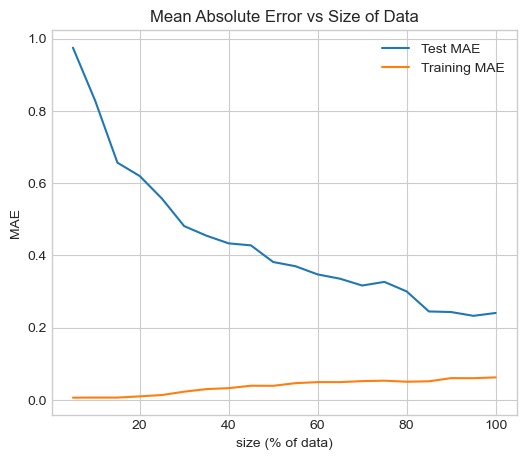

In [214]:

train_mae_by_size = results[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [215]:
MAE_test = test_mae_by_size[-1].item()/y_test.mean()

print(f"Final MAE on Validation results: {test_mae_by_size[-1].item()}")
print(f"Mean of Validation results: {y_test.mean()}")
print(f"Percent Error on Validation mean: {round(100*MAE_test,1)}%\n")

print(f"Final MAE on Training results: {train_mae_by_size[-1].item()}")
print(f"Mean of Training results: {y_train.mean()}")
print(f"Percent Error on Training mean: {round(100*train_mae_by_size[-1].item()/y_train.mean(),1)}%")

Final MAE on Validation results: 0.24081134191425052
Mean of Validation results: 1.475907095691892
Percent Error on Validation mean: 16.3%

Final MAE on Training results: 0.06243763511613812
Mean of Training results: 1.5105242016336489
Percent Error on Training mean: 4.1%


### Random

In [216]:
# Strip out the erosion rates and set them as y
imputation_rand_y = y.copy()
imputation_rand_X = X.copy()

imputation_rand_X.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Target Hardness (GPa),Target Hardness from Vickers,Target Hardness from Rockwell,...,Erodent Fracture toughness (MPa*m^0.5),Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel,Target Ductile/Brittle_B,Target Ductile/Brittle_D
count,922.000000,922.000000,910.000000,536.000000,922.000000,922.000000,922.000000,913.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,148.359490,135.985535,52.063736,6.310082,78.024946,0.175705,1992.761388,2.402378,0.925163,0.057484,...,2.432115,0.854664,0.036876,0.844902,0.062907,0.814534,0.127983,0.057484,0.017354,0.982646
std,102.085206,87.332032,28.686238,6.976491,140.701718,0.380776,22.008722,1.359130,0.263271,0.232891,...,1.797402,0.352631,0.188560,0.362194,0.242927,0.388886,0.334252,0.232891,0.130656,0.130656
min,7.730000,10.000000,3.000000,0.760000,-7.000000,0.000000,1960.000000,0.200000,0.000000,0.000000,...,0.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,74.000000,30.000000,3.750000,21.000000,0.000000,1970.000000,1.100000,1.000000,0.000000,...,0.730000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,127.000000,108.000000,45.000000,5.000000,21.000000,0.000000,1995.000000,2.980000,1.000000,0.000000,...,0.730000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,210.000000,152.000000,90.000000,7.400000,21.000000,0.000000,2014.000000,3.100000,1.000000,0.000000,...,4.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,490.000000,554.000000,90.000000,50.000000,800.000000,1.000000,2023.000000,8.000000,1.000000,1.000000,...,4.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [217]:
# Generate random values within the column range
def fill_with_random(col):
  # Get non-NaN minimum and maximum values of the column
  col_min, col_max = col.min(), col.max()
  # Use a lambda to fill NaN values with random numbers in the range
  return col.apply(lambda x: np.random.uniform(col_min, col_max) if pd.isna(x) else x)

# Apply the function to each column of the DataFrame
imputation_rand_X = imputation_rand_X.apply(fill_with_random)

# Check that there are no remaining missing values
imputation_rand_X.isnull().sum()

Particle Size (µm)                        0
Velocity (m/s)                            0
Incident angle                            0
Nozzle Diameter (mm)                      0
Temperature (°C)                          0
ASTM G76 Mentioned?                       0
Publication Year                          0
Target Hardness (GPa)                     0
Target Hardness from Vickers              0
Target Hardness from Rockwell             0
Target Density (kg/m^3)                   0
Target Elastic Modulus (GPa)              0
Target Poisson Ratio                      0
Target Thermal conductivity (W/m*K)       0
Target Yield Strength (MPa)               0
Target Tensile Strength (MPa)             0
Target Fracture toughness (MPa*m^0.5)     0
Target Melting Temp (°C)                  0
Erodent Density (kg/m^3)                  0
Erodent Hardness (GPa)                    0
Erodent Melting Temp (°C)                 0
Erodent Young's Modulus (GPa)             0
Erodent Poisson's Ratio         

In [218]:
# Find a random state which gives a split with less than 5% difference in the y values
scaling_factor = 0

i=-1
while not 0.95 <= scaling_factor <= 1.05:
  i += 1
  X_train, X_test, y_train, y_test = train_test_split(imputation_rand_X, imputation_rand_y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
  scaling_factor = y_train.mean()/y_test.mean()
  
print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Validation results: {y_test.mean()}")
print(f"scaling factor: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")


Mean of Training results: 1.5105242016336489
Mean of Validation results: 1.475907095691892
scaling factor: 1.0234548001312567
random_state: 1


In [219]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
xgbr = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
xgbr.fit(X_train, y_train)

# print best parameter after tuning
print(xgbr.best_params_)

{'learning_rate': 0.25, 'n_estimators': 150}


In [220]:
# {'learning_rate': 0.25, 'n_estimators': 150} : Optimized

n_est = xgbr.best_params_['n_estimators']
lr = xgbr.best_params_['learning_rate']

In [221]:
results = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(n_estimators=n_est, learning_rate=lr))
#results = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.25, n_estimators=150))

Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

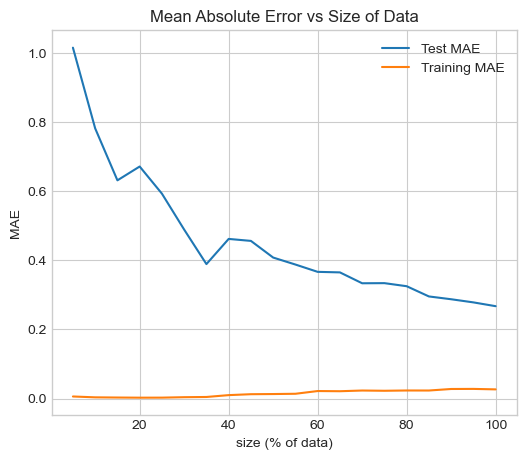

In [222]:

train_mae_by_size = results[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [223]:
MAE_test = test_mae_by_size[-1].item()/y_test.mean()

print(f"Final MAE on Validation results: {test_mae_by_size[-1].item()}")
print(f"Mean of Validation results: {y_test.mean()}")
print(f"Percent Error on Validation mean: {round(100*MAE_test,1)}%\n")

print(f"Final MAE on Training results: {train_mae_by_size[-1].item()}")
print(f"Mean of Training results: {y_train.mean()}")
print(f"Percent Error on Training mean: {round(100*train_mae_by_size[-1].item()/y_train.mean(),1)}%")

Final MAE on Validation results: 0.2674431039486968
Mean of Validation results: 1.475907095691892
Percent Error on Validation mean: 18.1%

Final MAE on Training results: 0.026695673811527054
Mean of Training results: 1.5105242016336489
Percent Error on Training mean: 1.8%


### MICE

In [224]:
# Strip out the erosion rates and set them as y
imputation_MICE_y = y.copy()
imputation_MICE_X = X.copy()

imputation_MICE_X.describe()

,Particle Size (µm),Velocity (m/s),Incident angle,Nozzle Diameter (mm),Temperature (°C),ASTM G76 Mentioned?,Publication Year,Target Hardness (GPa),Target Hardness from Vickers,Target Hardness from Rockwell,...,Erodent Fracture toughness (MPa*m^0.5),Shape_Angular,Shape_Spherical,Carrier Gas_Air,Carrier Gas_Nitrogen,Test type_Gas Blast,Test type_Whirling Arm,Test type_Windtunnel,Target Ductile/Brittle_B,Target Ductile/Brittle_D
count,922.000000,922.000000,910.000000,536.000000,922.000000,922.000000,922.000000,913.000000,922.000000,922.000000,...,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,148.359490,135.985535,52.063736,6.310082,78.024946,0.175705,1992.761388,2.402378,0.925163,0.057484,...,2.432115,0.854664,0.036876,0.844902,0.062907,0.814534,0.127983,0.057484,0.017354,0.982646
std,102.085206,87.332032,28.686238,6.976491,140.701718,0.380776,22.008722,1.359130,0.263271,0.232891,...,1.797402,0.352631,0.188560,0.362194,0.242927,0.388886,0.334252,0.232891,0.130656,0.130656
min,7.730000,10.000000,3.000000,0.760000,-7.000000,0.000000,1960.000000,0.200000,0.000000,0.000000,...,0.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,74.000000,30.000000,3.750000,21.000000,0.000000,1970.000000,1.100000,1.000000,0.000000,...,0.730000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,127.000000,108.000000,45.000000,5.000000,21.000000,0.000000,1995.000000,2.980000,1.000000,0.000000,...,0.730000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,210.000000,152.000000,90.000000,7.400000,21.000000,0.000000,2014.000000,3.100000,1.000000,0.000000,...,4.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,490.000000,554.000000,90.000000,50.000000,800.000000,1.000000,2023.000000,8.000000,1.000000,1.000000,...,4.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [225]:
# Create mask for missing values
missing_mask = imputation_MICE_X.isna()

#Instantiate the MICE imputer
imputer = IterativeImputer(max_iter=10, random_state=0)

#Fit the imputer on the data and transform it to obtain the imputed values
imputed_values = imputer.fit_transform(imputation_MICE_X)

# Convert imputed values back to a DataFrame with the same structure as X_mice
imputed_df = pd.DataFrame(imputed_values, index=imputation_MICE_X.index, columns=imputation_MICE_X.columns)

#Replace the missing values in the original dataset with the imputed values
imputation_MICE_X[missing_mask] = imputed_df[missing_mask]

imputation_MICE_X.isnull().sum()

C:\Development\anaconda3\envs\ML\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Particle Size (µm)                        0
Velocity (m/s)                            0
Incident angle                            0
Nozzle Diameter (mm)                      0
Temperature (°C)                          0
ASTM G76 Mentioned?                       0
Publication Year                          0
Target Hardness (GPa)                     0
Target Hardness from Vickers              0
Target Hardness from Rockwell             0
Target Density (kg/m^3)                   0
Target Elastic Modulus (GPa)              0
Target Poisson Ratio                      0
Target Thermal conductivity (W/m*K)       0
Target Yield Strength (MPa)               0
Target Tensile Strength (MPa)             0
Target Fracture toughness (MPa*m^0.5)     0
Target Melting Temp (°C)                  0
Erodent Density (kg/m^3)                  0
Erodent Hardness (GPa)                    0
Erodent Melting Temp (°C)                 0
Erodent Young's Modulus (GPa)             0
Erodent Poisson's Ratio         

In [226]:
# Find a random state which gives a split with less than 5% difference in the y values
scaling_factor = 0

i=-1
while not 0.95 <= scaling_factor <= 1.05:
  i += 1
  X_train, X_test, y_train, y_test = train_test_split(imputation_MICE_X, imputation_MICE_y, train_size=0.8, test_size=0.2,
                                                        random_state=i, shuffle=True)
  scaling_factor = y_train.mean()/y_test.mean()
  
print(f"Mean of Training results: {y_train.mean()}")
print(f"Mean of Validation results: {y_test.mean()}")
print(f"scaling factor: {y_train.mean()/y_test.mean()}")
print(f"random_state: {i}")


Mean of Training results: 1.5105242016336489
Mean of Validation results: 1.475907095691892
scaling factor: 1.0234548001312567
random_state: 1


In [227]:
parameters = {'n_estimators':[50 * i for i in range(1, 16)], 'learning_rate':[0.005 * i for i in range(1, 51)]}

GridSearch_model = XGBRegressor()
xgbr = GridSearchCV(GridSearch_model, parameters, n_jobs=-3)
xgbr.fit(X_train, y_train)

# print best parameter after tuning
print(xgbr.best_params_)

{'learning_rate': 0.25, 'n_estimators': 150}


In [228]:
# {'learning_rate': 0.25, 'n_estimators': 150} : Optimized

n_est = xgbr.best_params_['n_estimators']
lr = xgbr.best_params_['learning_rate']

In [229]:
results = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(n_estimators=n_est, learning_rate=lr))
#results = data_size_tester(X_train, y_train, X_test, y_test, XGBRegressor(learning_rate=0.25, n_estimators=150))

Text(0.5, 1.0, 'Mean Absolute Error vs Size of Data')

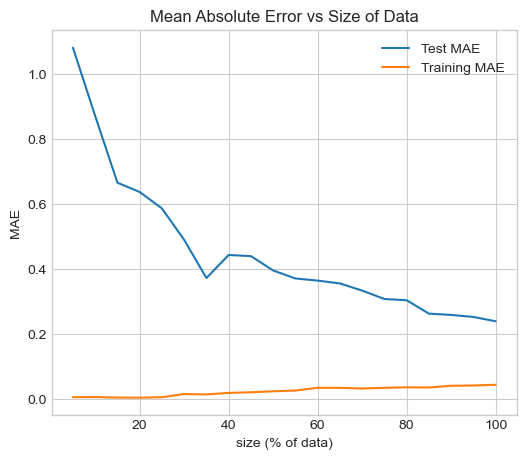

In [230]:
train_mae_by_size = results[:, [0]] #Training MAE that these different sizes of data yield
test_mae_by_size = results[:, [1]] #Validation MAE that these different sizes of data yield
tested_size = results[:, [2]]

rcParams['figure.figsize']=6,5
plt.plot(tested_size,test_mae_by_size, label="Test MAE")
plt.plot(tested_size,train_mae_by_size, label = "Training MAE")
plt.legend()
plt.xlabel('size (% of data)')
plt.ylabel('MAE')
plt.title("Mean Absolute Error vs Size of Data")

In [231]:
MAE_test = test_mae_by_size[-1].item()/y_test.mean()

print(f"Final MAE on Validation results: {test_mae_by_size[-1].item()}")
print(f"Mean of Validation results: {y_test.mean()}")
print(f"Percent Error on Validation mean: {round(100*MAE_test,1)}%\n")

print(f"Final MAE on Training results: {train_mae_by_size[-1].item()}")
print(f"Mean of Training results: {y_train.mean()}")
print(f"Percent Error on Training mean: {round(100*train_mae_by_size[-1].item()/y_train.mean(),1)}%")

Final MAE on Validation results: 0.23949628057366512
Mean of Validation results: 1.475907095691892
Percent Error on Validation mean: 16.2%

Final MAE on Training results: 0.044072265294355026
Mean of Training results: 1.5105242016336489
Percent Error on Training mean: 2.9%


# END
